In [1]:
# Cell 1: Initialize Binance Client for Binance.US (stdout Logging)

import os
import logging
import sys # Import sys to specify stdout stream
from binance.client import Client
from binance.exceptions import BinanceAPIException, BinanceRequestException
from dotenv import load_dotenv

# --- Configuration ---
load_dotenv(verbose=False) # Load .env without verbose output

# Setup logging: Remove existing handlers and configure for INFO to stdout
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    stream=sys.stdout) # Explicitly direct logs to stdout

# Try to get API Key
API_KEY = os.environ.get('BINANCE_API_KEY')
# Try to get Secret Key using common names
SECRET_KEY = os.environ.get('BINANCE_SECRET_KEY')
if not SECRET_KEY:
    SECRET_KEY = os.environ.get('BINANCE_API_SECRET')

TARGET_TLD = 'us'

# --- Initialize Client ---
client = None
logging.info("--- Initializing Binance Client ---")
if not API_KEY or not SECRET_KEY:
    # Log error only if keys are definitively missing
    logging.error("Binance API Key or Secret Key not found in environment variables.")
    logging.error("Please ensure BINANCE_API_KEY and either BINANCE_SECRET_KEY or BINANCE_API_SECRET are set.")
else:
    try:
        client = Client(API_KEY, SECRET_KEY, tld=TARGET_TLD)
        client.ping()
        logging.info(f"✅ Binance client initialized and ping successful for tld='{TARGET_TLD}'.")

    except BinanceAPIException as e:
        logging.error(f"❌ Binance API Exception during initialization or ping: {e}")
        if e.code == -2015:
             logging.error("Authentication Error: Invalid API Key or Secret Key permissions/IP restrictions.")
        client = None
    except BinanceRequestException as e:
        logging.error(f"❌ Binance Request Exception during initialization or ping: {e}")
        client = None
    except Exception as e:
        logging.error(f"❌ An unexpected error occurred during client initialization: {e}")
        client = None

# --- Final Verification ---
if client:
    logging.info("Binance client is ready.")
else:
    logging.warning("Binance client initialization failed. Cannot proceed.")
    # raise RuntimeError("Client initialization failed.") # Optionally raise error

# End of Cell 1

2025-04-10 03:04:04,491 - INFO - --- Initializing Binance Client ---
2025-04-10 03:04:04,962 - INFO - ✅ Binance client initialized and ping successful for tld='us'.
2025-04-10 03:04:04,963 - INFO - Binance client is ready.


In [2]:
# Cell 2: Fetch Initial Portfolio State (Balances and Open Orders) - Print Output

import pandas as pd
from decimal import Decimal, ROUND_DOWN, InvalidOperation
import logging
import sys

# --- Configuration for Display ---
DISPLAY_PRECISION = 8
pd.set_option('display.float_format', f'{{:.{DISPLAY_PRECISION}f}}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# --- Logging configured in Cell 1 ---
# No need to call basicConfig again if Cell 1 was run in the same session.

# --- Ensure client exists (from Cell 1) ---
if 'client' not in locals() or client is None:
    # Use logging for errors/warnings as configured in Cell 1
    logging.error("Binance client not initialized. Cannot fetch portfolio state.")
    portfolio_state = {"balances": pd.DataFrame(), "open_orders": pd.DataFrame(), "error": "Client not initialized"}
else:
    # logging.info("Client found. Proceeding to fetch portfolio state.") # Can be removed - less verbose

    # --- Helper Function Definitions (Less Logging) ---

    def get_current_balances_detailed(api_client):
        """ Fetches detailed balances using Decimal. Less verbose logging. """
        balances_df = pd.DataFrame(columns=['Asset', 'Free', 'Locked']).set_index('Asset')
        try:
            account_info = api_client.get_account()
            balances_raw = account_info.get('balances', [])
            processed_balances = []
            for item in balances_raw:
                try:
                    free_dec = Decimal(item['free'])
                    locked_dec = Decimal(item['locked'])
                    if free_dec > Decimal(0) or locked_dec > Decimal(0):
                         processed_balances.append({'Asset': item['asset'], 'Free': free_dec, 'Locked': locked_dec})
                except InvalidOperation:
                    logging.warning(f"Could not convert balance: asset {item.get('asset', 'N/A')}, free='{item.get('free')}', locked='{item.get('locked')}'") # Keep warnings
                except Exception as e:
                     logging.warning(f"Error processing balance for asset {item.get('asset', 'N/A')}: {e}") # Keep warnings

            if processed_balances:
                balances_df = pd.DataFrame(processed_balances)
                balances_df.set_index('Asset', inplace=True)
            # logging.info(f"Successfully fetched and processed {len(balances_df)} asset balances.") # Removed - less verbose
            return balances_df
        except BinanceAPIException as e:
            logging.error(f"Binance API Exception fetching balances: {e}") # Keep errors
        except BinanceRequestException as e:
            logging.error(f"Binance Request Exception fetching balances: {e}") # Keep errors
        except Exception as e:
            logging.error(f"Unexpected error fetching balances: {e}") # Keep errors
        return balances_df


    def get_open_orders_detailed(api_client, symbol=None):
        """ Fetches detailed open orders using Decimal. Less verbose logging. """
        orders_df = pd.DataFrame()
        try:
            if symbol:
                # logging.info(f"Fetching open orders for symbol: {symbol}") # Removed - less verbose
                open_orders_raw = api_client.get_open_orders(symbol=symbol)
            else:
                # logging.info("Fetching all open orders.") # Removed - less verbose
                open_orders_raw = api_client.get_open_orders()

            if not open_orders_raw:
                # logging.info("No open orders found.") # Removed - less verbose (covered by print output)
                return orders_df

            orders_df = pd.DataFrame(open_orders_raw)
            numeric_cols = ['price', 'origQty', 'executedQty', 'cummulativeQuoteQty', 'stopPrice']
            for col in numeric_cols:
                if col in orders_df.columns:
                    orders_df[col] = orders_df[col].apply(lambda x: Decimal(str(x)) if x is not None else Decimal('0'))
            ts_cols = ['time', 'updateTime']
            for col in ts_cols:
                 if col in orders_df.columns:
                     orders_df[col] = pd.to_datetime(orders_df[col], unit='ms', utc=True, errors='coerce')
            orders_df = orders_df.sort_values(by=['symbol', 'time'], ascending=[True, False]).reset_index(drop=True)
            # logging.info(f"Successfully fetched and processed {len(orders_df)} open orders.") # Removed - less verbose
            return orders_df
        except BinanceAPIException as e:
            logging.error(f"Binance API Exception fetching open orders: {e}") # Keep errors
        except BinanceRequestException as e:
            logging.error(f"Binance Request Exception fetching open orders: {e}") # Keep errors
        except Exception as e:
            logging.error(f"Unexpected error fetching open orders: {e}") # Keep errors
        return orders_df

    # --- Formatting Function for Printing Decimals ---
    def format_decimal_for_print(d, precision=DISPLAY_PRECISION):
        """ Formats a Decimal as a fixed-point string for printing. """
        if isinstance(d, Decimal):
            return f"{d:.{precision}f}"
        return d

    # --- Main Execution Logic for this Cell ---
    logging.info("--- Fetching Portfolio State ---") # Keep start message
    portfolio_state = {
        "timestamp": pd.Timestamp.utcnow(),
        "balances": pd.DataFrame(),
        "open_orders": pd.DataFrame(),
        "error": None
    }

    try:
        portfolio_state["balances"] = get_current_balances_detailed(client)
        portfolio_state["open_orders"] = get_open_orders_detailed(client)

        # --- Print Output With Explicit Decimal Formatting ---
        # Keep print statements for primary output
        print("\n--- Portfolio State Summary ---")
        if not portfolio_state["balances"].empty:
            print(f"Balances ({len(portfolio_state['balances'])} assets found):")
            balances_to_print = portfolio_state["balances"].copy()
            balances_to_print['Free'] = balances_to_print['Free'].apply(format_decimal_for_print)
            balances_to_print['Locked'] = balances_to_print['Locked'].apply(format_decimal_for_print)
            print(balances_to_print)
        else:
            print("Balances: None found or error during fetch.")

        if not portfolio_state["open_orders"].empty:
            print(f"\nOpen Orders ({len(portfolio_state['open_orders'])} found):")
            orders_to_print = portfolio_state["open_orders"].copy()
            display_cols = ['symbol', 'orderId', 'side', 'type', 'price', 'origQty', 'time']
            display_cols_present = [c for c in display_cols if c in orders_to_print.columns]
            decimal_order_cols = ['price', 'origQty'] # Add others if needed
            for col in decimal_order_cols:
                if col in orders_to_print.columns:
                     orders_to_print[col] = orders_to_print[col].apply(format_decimal_for_print)
            if 'time' in orders_to_print.columns:
                 orders_to_print['time'] = orders_to_print['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
            print(orders_to_print[display_cols_present])
        else:
            print("\nOpen Orders: None found or error during fetch.")

        logging.info("✅ Portfolio state captured.") # Keep success message

    except Exception as state_fetch_error:
         logging.error(f"❌ Critical error during state fetching: {state_fetch_error}") # Keep errors
         print(f"\n❌ Error fetching state: {state_fetch_error}") # Keep errors
         portfolio_state["error"] = str(state_fetch_error)


# Final summary using print - Keep this
print(f"\nPortfolio State Fetch Timestamp (UTC): {portfolio_state.get('timestamp')}")
print(f"Balances Fetched: {not portfolio_state.get('balances', pd.DataFrame()).empty}")
print(f"Open Orders Fetched: {not portfolio_state.get('open_orders', pd.DataFrame()).empty}")
print(f"Errors During Fetch: {portfolio_state.get('error')}")

# End of Cell 2

2025-04-10 03:04:05,217 - INFO - --- Fetching Portfolio State ---

--- Portfolio State Summary ---
Balances (11 assets found):
              Free      Locked
Asset                         
BTC     0.00000672  0.00000000
ETH     0.00008360  0.00000000
XRP     2.96400000  0.00000000
USDT   24.53460092  0.00000000
ADA     0.07600000  0.00000000
LINK    0.00920000  0.00000000
BUSD    0.14956400  0.00000000
WAVES   0.01000000  0.00000000
USDC    1.98800000  0.00000000
HBAR   12.89200000  0.00000000
SOL     0.00088000  0.00000000

Open Orders: None found or error during fetch.
2025-04-10 03:04:05,421 - INFO - ✅ Portfolio state captured.

Portfolio State Fetch Timestamp (UTC): 2025-04-10 03:04:05.218582+00:00
Balances Fetched: True
Open Orders Fetched: False
Errors During Fetch: None


In [3]:
# Cell 3: Define MVP Parameters and Fetch Market Data (Using pandas_ta)

import pandas as pd
import pandas_ta as ta
from decimal import Decimal, ROUND_DOWN
import logging
from binance.exceptions import BinanceAPIException, BinanceRequestException
import numpy as np

# --- Logging configured in Cell 1 ---
# No need to call basicConfig again

# --- Ensure client exists (from Cell 1) ---
if 'client' not in locals() or client is None:
    logging.error("Binance client not initialized. Cannot fetch market data.")
    market_data = {"error": "Client not initialized"}
else:
    # logging.info("Client found. Proceeding...") # Removed - less verbose

    # --- MVP Configuration Parameters ---
    TRADING_SYMBOL = 'BTCUSDT'
    QUOTE_ASSET = 'USDT'
    KLINE_INTERVAL = client.KLINE_INTERVAL_1HOUR
    KLINE_HISTORY = "30 days ago UTC"
    ATR_PERIOD = 14

    PRICE_PRECISION = 2
    ATR_PRECISION = 2
    QTY_PRECISION = 8

    # Keep parameter logging - it's useful configuration info
    logging.info(f"--- MVP Parameters ---")
    logging.info(f"Trading Symbol: {TRADING_SYMBOL}")
    logging.info(f"Quote Asset: {QUOTE_ASSET}")
    logging.info(f"Kline Interval: {KLINE_INTERVAL}")
    logging.info(f"Kline History: {KLINE_HISTORY}")
    logging.info(f"ATR Period: {ATR_PERIOD}")

    # --- Data Fetching and Processing ---
    market_data = {
        "symbol": TRADING_SYMBOL,
        "current_price": None,
        "current_atr": None,
        "kline_interval": KLINE_INTERVAL,
        "atr_period": ATR_PERIOD,
        "kline_data": pd.DataFrame(),
        "timestamp": None,
        "error": None
    }

    try:
        # logging.info(f"\nFetching klines for {TRADING_SYMBOL}...") # Removed - less verbose
        klines_raw = client.get_historical_klines(TRADING_SYMBOL, KLINE_INTERVAL, KLINE_HISTORY)

        if not klines_raw:
             raise ValueError(f"No kline data returned for {TRADING_SYMBOL}")

        klines_df = pd.DataFrame(klines_raw, columns=[
            'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close Time', 'Quote Asset Volume', 'Number of Trades',
            'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'
        ])

        klines_df['Open Time'] = pd.to_datetime(klines_df['Open Time'], unit='ms', utc=True)
        klines_df['Close Time'] = pd.to_datetime(klines_df['Close Time'], unit='ms', utc=True)
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # Add others if needed
        for col in numeric_cols:
             klines_df[col] = klines_df[col].apply(lambda x: Decimal(str(x)))

        klines_df = klines_df[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time']].copy()
        klines_df.set_index('Close Time', inplace=True)

        market_data["kline_data"] = klines_df
        # logging.info(f"Successfully processed {len(klines_df)} klines.") # Removed - less verbose

        # --- Calculate Indicators using pandas_ta ---
        # logging.info(f"Calculating ATR({ATR_PERIOD}) using pandas-ta...") # Removed - less verbose

        if len(klines_df) < ATR_PERIOD:
            raise ValueError(f"Not enough kline data ({len(klines_df)}) for ATR period {ATR_PERIOD}.")

        klines_df_float = klines_df[['Open', 'High', 'Low', 'Close']].astype(float)
        klines_df_float.ta.atr(length=ATR_PERIOD, append=True)

        latest_data = klines_df_float.iloc[-1]
        latest_close_price_float = latest_data['Close']
        latest_atr_float = latest_data[f'ATRr_{ATR_PERIOD}']

        if pd.isna(latest_atr_float):
             raise ValueError("ATR calculation resulted in NaN.")

        market_data["current_price"] = Decimal(str(latest_close_price_float))
        market_data["current_atr"] = Decimal(str(latest_atr_float))
        market_data["timestamp"] = pd.Timestamp.utcnow()

        # logging.info("pandas-ta ATR calculation successful.") # Removed - less verbose

        # --- Output Current Market Data ---
        # Keep print statements for primary output
        price_str = f"{market_data['current_price']:.{PRICE_PRECISION}f}"
        atr_str = f"{market_data['current_atr']:.{ATR_PRECISION}f}"

        print(f"\n--- Current Market Data ({TRADING_SYMBOL}) ---")
        print(f"Timestamp (UTC): {market_data['timestamp']}")
        print(f"Latest Close Price: {price_str}")
        print(f"Latest ATR ({ATR_PERIOD} periods): {atr_str}")
        logging.info("✅ Market data fetched and processed successfully.") # Keep success message

    except BinanceAPIException as e:
        logging.error(f"❌ Binance API Exception fetching market data: {e}") # Keep errors
        market_data["error"] = str(e)
    except BinanceRequestException as e:
        logging.error(f"❌ Binance Request Exception fetching market data: {e}") # Keep errors
        market_data["error"] = str(e)
    except ValueError as e:
         logging.error(f"❌ Data Processing Error: {e}") # Keep errors
         market_data["error"] = str(e)
    except Exception as e:
        logging.error(f"❌ An unexpected error occurred fetching market data: {e}") # Keep errors
        market_data["error"] = str(e)
        import traceback
        logging.error(traceback.format_exc()) # Keep full traceback for unexpected


# Final summary using print - Keep this
print(f"\nMarket Data Fetch Status:")
print(f"  Symbol: {market_data.get('symbol')}")
print(f"  Price Fetched: {market_data.get('current_price') is not None}")
print(f"  ATR Fetched: {market_data.get('current_atr') is not None}")
print(f"  Error: {market_data.get('error')}")

# End of Cell 3

2025-04-10 03:04:05,558 - INFO - --- MVP Parameters ---
2025-04-10 03:04:05,559 - INFO - Trading Symbol: BTCUSDT
2025-04-10 03:04:05,559 - INFO - Quote Asset: USDT
2025-04-10 03:04:05,560 - INFO - Kline Interval: 1h
2025-04-10 03:04:05,560 - INFO - Kline History: 30 days ago UTC
2025-04-10 03:04:05,561 - INFO - ATR Period: 14

--- Current Market Data (BTCUSDT) ---
Timestamp (UTC): 2025-04-10 03:04:05.785938+00:00
Latest Close Price: 82075.83
Latest ATR (14 periods): 855.88
2025-04-10 03:04:05,786 - INFO - ✅ Market data fetched and processed successfully.

Market Data Fetch Status:
  Symbol: BTCUSDT
  Price Fetched: True
  ATR Fetched: True
  Error: None


In [8]:
# Cell 3.5: Initialize SQLite Database and Create Tables

import sqlite3
import logging
import os
from datetime import datetime, timezone

# --- Configuration ---
DATABASE_FILE = 'geminitrader_log.db'
logging.info(f"--- Database Setup: Using file '{DATABASE_FILE}' ---")

# --- Database Connection Function ---
def get_db_connection():
    """Establishes a connection to the SQLite database."""
    try:
        conn = sqlite3.connect(DATABASE_FILE)
        # Optional: Set row factory for dictionary-like access if needed later
        # conn.row_factory = sqlite3.Row
        logging.debug("Database connection established.") # Use debug level for less noise
        return conn
    except sqlite3.Error as e:
        logging.error(f"❌ Database connection error: {e}")
        raise # Re-raise the exception to halt if connection fails

# --- Table Creation Function ---
def create_tables(conn):
    """Creates the necessary tables if they don't already exist."""
    try:
        cursor = conn.cursor()

        # Planned Orders Table (from Cell 4)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS PlannedOrders (
            planned_order_id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp TEXT NOT NULL,
            symbol TEXT NOT NULL,
            level INTEGER,
            planned_price TEXT NOT NULL, -- Store Decimal as string
            planned_qty TEXT NOT NULL,   -- Store Decimal as string
            planned_notional TEXT NOT NULL, -- Store Decimal as string
            price_tick_size TEXT,       -- Store Decimal as string
            qty_step_size TEXT,         -- Store Decimal as string
            current_price_at_plan TEXT, -- Store Decimal as string (optional)
            current_atr_at_plan TEXT    -- Store Decimal as string (optional)
        );
        """)
        logging.debug("Checked/Created PlannedOrders table.")

        # Placed BUY Orders Table (from Cell 5)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS PlacedBuyOrders (
            placement_id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp TEXT NOT NULL,
            symbol TEXT NOT NULL,
            level INTEGER,             -- Context from planning
            price_sent TEXT NOT NULL,  -- Formatted string sent to API
            quantity_sent TEXT NOT NULL, -- Formatted string sent to API
            status TEXT NOT NULL,      -- 'SUCCESS' or 'FAILED'
            binance_order_id TEXT,     -- Binance Order ID if SUCCESS
            error_code INTEGER,        -- Binance error code if FAILED
            error_message TEXT         -- Binance error message if FAILED
        );
        """)
        logging.debug("Checked/Created PlacedBuyOrders table.")

        # Filled BUY Orders Table (from Cell 6)
        # Stores aggregated fill info per successfully placed BUY order
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS FilledBuyOrders (
            fill_log_id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp TEXT NOT NULL,          -- Time fill was detected/logged
            binance_buy_order_id TEXT NOT NULL UNIQUE, -- The ID of the BUY order that filled
            symbol TEXT NOT NULL,
            avg_fill_price TEXT NOT NULL,     -- Store Decimal as string
            total_filled_qty TEXT NOT NULL,   -- Store Decimal as string
            total_cost TEXT NOT NULL          -- Store Decimal as string (quote asset cost)
        );
        """)
        logging.debug("Checked/Created FilledBuyOrders table.")

        # Placed Take Profit (SELL) Orders Table (from Cell 6)
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS PlacedTpOrders (
            tp_placement_id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp TEXT NOT NULL,
            binance_buy_order_id TEXT NOT NULL, -- Links back to the filled BUY order
            symbol TEXT NOT NULL,
            tp_price_sent TEXT NOT NULL,        -- Formatted string sent to API
            tp_quantity_sent TEXT NOT NULL,     -- Formatted string sent to API
            status TEXT NOT NULL,               -- 'SUCCESS' or 'FAILED'
            binance_sell_order_id TEXT,         -- Binance TP Order ID if SUCCESS
            error_code INTEGER,                 -- Binance error code if FAILED
            error_message TEXT                  -- Binance error message if FAILED
        );
        """)
        logging.debug("Checked/Created PlacedTpOrders table.")

        conn.commit()
        logging.info("✅ Database tables checked/created successfully.")

    except sqlite3.Error as e:
        logging.error(f"❌ Error creating tables: {e}")
        conn.rollback() # Rollback changes if table creation fails
        raise # Re-raise to signal failure

# --- Main Execution for this Cell ---
try:
    conn = get_db_connection()
    create_tables(conn)
    conn.close()
    logging.info("Database setup cell completed.")
except Exception as e:
    logging.error(f"❌ Failed to complete database setup: {e}")
    # Depending on severity, might want to raise SystemExit or just log

# End of Cell 3.5

2025-04-10 03:36:51,569 - INFO - --- Database Setup: Using file 'geminitrader_log.db' ---
2025-04-10 03:36:52,251 - INFO - ✅ Database tables checked/created successfully.
2025-04-10 03:36:52,253 - INFO - Database setup cell completed.


In [10]:
# Cell 3.6: Database Logging Helper Functions

import sqlite3
import logging
from datetime import datetime, timezone
from decimal import Decimal # Import Decimal for type hinting and conversion

# --- Database File (defined in Cell 3.5, but needed here for connection) ---
DATABASE_FILE = 'geminitrader_log.db'

# --- Helper to get connection (copied for self-containment, can be refactored later) ---
def get_db_connection():
    """Establishes a connection to the SQLite database."""
    try:
        conn = sqlite3.connect(DATABASE_FILE)
        logging.debug("DB connection obtained for logging.")
        return conn
    except sqlite3.Error as e:
        logging.error(f"❌ Database connection error during logging attempt: {e}")
        return None # Return None to indicate failure

# --- Helper to safely format Decimals (or other types) to string ---
def safe_format(value, default_precision=18):
    """Safely formats Decimal to string, handles None or other types."""
    if isinstance(value, Decimal):
        # Using to_eng_string() avoids scientific notation and preserves precision
        return value.to_eng_string()
    elif value is None:
        return None # Store None as NULL in the database
    else:
        # Attempt to convert other types (like int, float) to string
        try:
            # If it might be float-like, format to avoid potential sci notation
            if isinstance(value, (float, int)):
                 # Use f-string formatting as a robust fallback for floats/ints
                 return f"{Decimal(str(value)):.{default_precision}f}"
            return str(value)
        except Exception:
            # Fallback for unexpected types
            return str(value)


# --- Logging Function for Planned Orders (from Cell 4) ---
def log_planned_order(plan_details: dict):
    """Logs a single planned order into the PlannedOrders table."""
    conn = get_db_connection()
    if not conn: return False

    required_keys = ['symbol', 'level', 'price_adjusted', 'qty_adjusted', 'notional_value']
    if not all(key in plan_details for key in required_keys):
        logging.error("❌ Missing required keys in plan_details for logging.")
        return False

    try:
        cursor = conn.cursor()
        ts = datetime.now(timezone.utc).isoformat()

        # Prepare data, formatting Decimals safely
        data_to_insert = (
            ts,
            plan_details.get('symbol'),
            plan_details.get('level'),
            safe_format(plan_details.get('price_adjusted')),
            safe_format(plan_details.get('qty_adjusted')),
            safe_format(plan_details.get('notional_value')),
            safe_format(plan_details.get('price_tick_size')),
            safe_format(plan_details.get('qty_step_size')),
            # Optional fields: Add if available in plan_details later
            # safe_format(plan_details.get('current_price')),
            # safe_format(plan_details.get('current_atr'))
        )

        sql = """
        INSERT INTO PlannedOrders (
            timestamp, symbol, level, planned_price, planned_qty, planned_notional,
            price_tick_size, qty_step_size
            -- Add optional columns here if used: , current_price_at_plan, current_atr_at_plan
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?);
        """ # Adjust VALUES(?, ?, ...) count if optional fields added

        cursor.execute(sql, data_to_insert)
        conn.commit()
        logging.debug(f"Logged planned order for {plan_details.get('symbol')} Lvl {plan_details.get('level')}")
        return True
    except sqlite3.Error as e:
        logging.error(f"❌ Error logging planned order: {e}")
        conn.rollback()
        return False
    finally:
        if conn:
            conn.close()


# --- Logging Function for Placed BUY Orders (from Cell 5) ---
def log_placed_buy_order(placement_result: dict):
    """Logs the result of a BUY order placement attempt."""
    conn = get_db_connection()
    if not conn: return False

    # Determine status and extract relevant fields
    is_success = 'order_info' in placement_result and placement_result.get('order_info') is not None
    status = 'SUCCESS' if is_success else 'FAILED'
    symbol = placement_result.get('symbol')
    level = placement_result.get('level') # Keep level for context

    if is_success:
        order_info = placement_result['order_info']
        price_sent = safe_format(Decimal(order_info.get('price', '0'))) # Comes back as string
        quantity_sent = safe_format(Decimal(order_info.get('origQty', '0'))) # Comes back as string
        binance_order_id = str(order_info.get('orderId'))
        error_code = None
        error_message = None
    else: # Failed placement
        # Assume price/qty strings were stored in the 'failed' dict if available
        price_sent = placement_result.get('price_str', 'N/A')
        quantity_sent = placement_result.get('quantity_str', 'N/A')
        binance_order_id = None
        error_code = placement_result.get('error_code')
        error_message = placement_result.get('error_message')

    try:
        cursor = conn.cursor()
        ts = datetime.now(timezone.utc).isoformat()

        data_to_insert = (
            ts, symbol, level, price_sent, quantity_sent,
            status, binance_order_id, error_code, error_message
        )

        sql = """
        INSERT INTO PlacedBuyOrders (
            timestamp, symbol, level, price_sent, quantity_sent, status,
            binance_order_id, error_code, error_message
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);
        """

        cursor.execute(sql, data_to_insert)
        conn.commit()
        logging.debug(f"Logged placed BUY order attempt for {symbol} Lvl {level}: {status}")
        return True
    except sqlite3.Error as e:
        logging.error(f"❌ Error logging placed BUY order: {e}")
        conn.rollback()
        return False
    finally:
        if conn:
            conn.close()


# --- Logging Function for Filled BUY Orders (from Cell 6) ---
def log_filled_buy(fill_data: dict):
    """Logs aggregated fill details for a specific BUY order."""
    conn = get_db_connection()
    if not conn: return False

    required_keys = ['order_id', 'symbol', 'qty', 'cost'] # Using keys from Cell 6' filled_buy_orders dict
    if not all(key in fill_data for key in required_keys):
        logging.error(f"❌ Missing required keys in fill_data for logging: {fill_data}")
        return False

    # Calculate avg price if not already present
    if 'avg_fill_price' not in fill_data and fill_data['qty'] > 0:
        avg_price = fill_data['cost'] / fill_data['qty']
    elif 'avg_fill_price' in fill_data:
         avg_price = fill_data['avg_fill_price']
    else:
         avg_price = Decimal('0') # Handle zero qty case

    try:
        cursor = conn.cursor()
        ts = datetime.now(timezone.utc).isoformat()
        buy_order_id = str(fill_data['order_id']) # Ensure it's a string

        data_to_insert = (
            ts,
            buy_order_id,
            fill_data['symbol'],
            safe_format(avg_price),
            safe_format(fill_data['qty']),
            safe_format(fill_data['cost'])
        )

        # Use INSERT OR IGNORE to prevent errors if we somehow detect the same fill twice
        sql = """
        INSERT OR IGNORE INTO FilledBuyOrders (
            timestamp, binance_buy_order_id, symbol, avg_fill_price,
            total_filled_qty, total_cost
        ) VALUES (?, ?, ?, ?, ?, ?);
        """

        cursor.execute(sql, data_to_insert)
        conn.commit()
        if cursor.rowcount > 0: # Check if insert happened
             logging.debug(f"Logged filled BUY order ID {buy_order_id}")
        else:
             logging.warning(f"Attempted to log duplicate fill for BUY order ID {buy_order_id}. Ignored.")
        return True
    except sqlite3.Error as e:
        logging.error(f"❌ Error logging filled BUY order {buy_order_id}: {e}")
        conn.rollback()
        return False
    finally:
        if conn:
            conn.close()


# --- Logging Function for Placed TP SELL Orders (from Cell 6) ---
def log_placed_tp_order(tp_placement_result: dict):
    """Logs the result of a Take Profit SELL order placement attempt."""
    conn = get_db_connection()
    if not conn: return False

    # Determine status and extract relevant fields
    is_success = 'sell_order_info' in tp_placement_result and tp_placement_result.get('sell_order_info') is not None
    status = 'SUCCESS' if is_success else 'FAILED'
    symbol = tp_placement_result.get('symbol')
    # *** Ensure 'buy_order_id' is present in the dict passed from Cell 6 ***
    buy_order_id = str(tp_placement_result.get('buy_order_id', 'UNKNOWN_BUY_ID'))

    if is_success:
        order_info = tp_placement_result['sell_order_info']
        tp_price_sent = safe_format(Decimal(order_info.get('price', '0')))
        tp_quantity_sent = safe_format(Decimal(order_info.get('origQty', '0')))
        binance_sell_order_id = str(order_info.get('orderId'))
        error_code = None
        error_message = None
    else: # Failed placement
        # Assume TP price/qty strings might be stored if available (modify Cell 6 if needed)
        tp_price_sent = tp_placement_result.get('tp_price_str', 'N/A')
        tp_quantity_sent = tp_placement_result.get('sell_quantity_str', 'N/A')
        binance_sell_order_id = None
        error_code = tp_placement_result.get('error_code')
        error_message = tp_placement_result.get('error_message')

    try:
        cursor = conn.cursor()
        ts = datetime.now(timezone.utc).isoformat()

        data_to_insert = (
            ts, buy_order_id, symbol, tp_price_sent, tp_quantity_sent,
            status, binance_sell_order_id, error_code, error_message
        )

        sql = """
        INSERT INTO PlacedTpOrders (
            timestamp, binance_buy_order_id, symbol, tp_price_sent, tp_quantity_sent,
            status, binance_sell_order_id, error_code, error_message
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);
        """

        cursor.execute(sql, data_to_insert)
        conn.commit()
        logging.debug(f"Logged placed TP SELL order attempt for BUY ID {buy_order_id}: {status}")
        return True
    except sqlite3.Error as e:
        logging.error(f"❌ Error logging placed TP SELL order for BUY ID {buy_order_id}: {e}")
        conn.rollback()
        return False
    finally:
        if conn:
            conn.close()

# --- Test Calls (Optional - uncomment to test functions) ---
# if __name__ == "__main__": # Prevents running when imported/run normally in notebook
#     logging.basicConfig(level=logging.DEBUG) # Need DEBUG to see logs from helpers
#     print("Testing logging functions...")
#
#     # Test Planned Order
#     test_plan = {
#         "symbol": "BTCUSDT", "level": 1, "price_adjusted": Decimal('60000.01'),
#         "qty_adjusted": Decimal('0.00017'), "notional_value": Decimal('10.20'),
#         "price_tick_size": Decimal('0.01'), "qty_step_size": Decimal('0.00001')
#     }
#     log_planned_order(test_plan)
#
#     # Test Successful Buy Placement
#     test_buy_success = {
#         "symbol": "BTCUSDT", "level": 1,
#         "order_info": {
#             "symbol": "BTCUSDT", "orderId": 12345, "price": "60000.01", "origQty": "0.00017",
#             # ... other fields from Binance ACK response ...
#         }
#     }
#     log_placed_buy_order(test_buy_success)
#
#     # Test Failed Buy Placement
#     test_buy_fail = {
#         "symbol": "ETHUSDT", "level": 2,
#         "price_str": "3000.00", "quantity_str": "0.001",
#         "error_code": -2010, "error_message": "Insufficient balance."
#     }
#     log_placed_buy_order(test_buy_fail)
#
#     # Test Fill Log
#     test_fill = {
#         "order_id": "12345", "symbol": "BTCUSDT",
#         "qty": Decimal("0.00017"), "cost": Decimal("10.199"), # Simulate slight price diff
#         "avg_fill_price": Decimal("59994.1176") # Calculated avg
#     }
#     log_filled_buy(test_fill)
#
#     # Test Successful TP Placement
#     test_tp_success = {
#         "buy_order_id": "12345", "symbol": "BTCUSDT",
#         "sell_order_info": {
#             "symbol": "BTCUSDT", "orderId": 67890, "price": "62000.00", "origQty": "0.00017"
#         }
#     }
#     log_placed_tp_order(test_tp_success)
#
#     # Test Failed TP Placement
#     test_tp_fail = {
#         "buy_order_id": "54321", "symbol": "ADAUSDT",
#         "tp_price_str": "1.50", "sell_quantity_str": "10.0",
#         "error_code": -1013, "error_message": "Filter failure: MIN_NOTIONAL"
#     }
#     log_placed_tp_order(test_tp_fail)
#
#     print("Finished testing logging functions.")


# End of Cell 3.6

In [11]:
# Cell 4: Plan Orders Iteratively (Integrated DB Logging for Planned Orders)

import pandas as pd
from decimal import Decimal, ROUND_DOWN, ROUND_UP, InvalidOperation
import logging
import math
import sys
# Import the logging function from Cell 3.6 (assuming notebook execution context)
# If running as separate scripts, you'd use proper imports (e.g., from db_loggers import log_planned_order)
if 'log_planned_order' not in locals():
    raise RuntimeError("log_planned_order function not defined. Run Cell 3.6 first.")

# --- Prerequisites ---
if 'client' not in locals() or client is None: raise RuntimeError("Binance client is missing.")
if 'portfolio_state' not in locals(): raise RuntimeError("Portfolio state is missing.")

logging.info("--- Planning Orders Iteratively (with DB Logging) ---")

# --- Configuration ---
NUM_SYMBOLS_TO_PROCESS = 10; QUOTE_ASSET = 'USDT'; MIN_24H_VOLUME_USDT = 100000
RESERVE_USDT_PERCENT = Decimal('0.25')
NUM_ORDERS_PER_SYMBOL = 5; QTY_SCALE_FACTOR = Decimal('1.2'); PRICE_DROP_ATR_MULTI = Decimal('0.3')
MIN_QTY_VALUE_MULTIPLE = Decimal('1.05') # Buffer still used for base scaling target
KLINE_INTERVAL = client.KLINE_INTERVAL_1HOUR; KLINE_HISTORY = "3 days ago UTC"

# --- Get Budget ---
available_free_usdt = Decimal('0')
balances_df_local = portfolio_state.get('balances', pd.DataFrame())
if QUOTE_ASSET in balances_df_local.index: available_free_usdt = balances_df_local.loc[QUOTE_ASSET, 'Free']
logging.info(f"Available FREE {QUOTE_ASSET} Balance: {available_free_usdt:.4f}")
reserved_usdt = available_free_usdt * RESERVE_USDT_PERCENT
planning_budget = available_free_usdt - reserved_usdt
logging.info(f"Reserving {RESERVE_USDT_PERCENT*100:.1f}% ({reserved_usdt:.4f}). Planning Budget: {planning_budget:.4f} USDT")
if planning_budget <= 0:
    logging.warning(f"Planning budget ({planning_budget:.4f}) <= 0. No orders will be planned.")
    all_planned_orders = [] # Ensure list exists but is empty
    # We can exit gracefully here instead of raising SystemExit to allow final summary
    # raise SystemExit(f"Exiting: Planning budget <= 0.")
else:
    # --- Fetch Data & Filter Symbols ---
    symbol_info_lookup = {}; ticker_lookup = {}
    try: # Fetch data
        logging.info("Fetching exchange info..."); exchange_info = client.get_exchange_info(); all_symbols_info = exchange_info.get('symbols', []); symbol_info_lookup = {s['symbol']: s for s in all_symbols_info}
        logging.info("Fetching all ticker prices/volumes..."); all_tickers_data = client.get_ticker(); ticker_lookup = {ticker['symbol']: ticker for ticker in all_tickers_data}
    except Exception as e: raise SystemExit(f"Failed to fetch data: {e}")
    potential_symbols = []
    for symbol, s_info in symbol_info_lookup.items(): # Build potential list
        if not symbol.endswith(QUOTE_ASSET) or s_info.get('status') != 'TRADING': continue
        ticker_info = ticker_lookup.get(symbol);
        if not ticker_info: continue
        try: # Process ticker
            volume = Decimal(ticker_info.get('quoteVolume', '0')); price_str = ticker_info.get('lastPrice', '0')
            price = Decimal(price_str);
            if price <= 0 or volume < MIN_24H_VOLUME_USDT: continue
            potential_symbols.append({"symbol": symbol, "volume_24h_usdt": volume, "price": price})
        except Exception: continue
    potential_symbols.sort(key=lambda x: x['volume_24h_usdt'], reverse=True)
    top_symbols_to_process = potential_symbols[:NUM_SYMBOLS_TO_PROCESS]
    logging.info(f"Selected Top {len(top_symbols_to_process)} Symbols: {[s['symbol'] for s in top_symbols_to_process]}")

    # --- Helper Functions (Ensure Defined) ---
    def adjust_price(price, tick_size):
        try:
            if not isinstance(price, Decimal) or not isinstance(tick_size, Decimal) or tick_size <= 0: return None
            return (price // tick_size) * tick_size
        except Exception: return None
    def adjust_qty(quantity, min_q, step_size):
        try:
            if quantity is None or min_q is None or step_size is None: return Decimal('0')
            if not isinstance(quantity,Decimal) or not isinstance(min_q,Decimal) or not isinstance(step_size,Decimal): return Decimal('0')
            if step_size <= 0: return Decimal('0');
            if quantity < min_q: return Decimal('0');
            num_steps = math.floor((quantity - min_q) / step_size); adj_qty = min_q + (num_steps * step_size); return adj_qty
        except Exception: return Decimal('0')
    def format_decimal_for_api(value: Decimal, step_or_tick_size: Decimal) -> str:
        try:
            if not isinstance(value, Decimal) or not isinstance(step_or_tick_size, Decimal) or step_or_tick_size <= 0: return f"{value:.8f}"
            decimal_places = abs(step_or_tick_size.normalize().as_tuple().exponent); return f"{value:.{decimal_places}f}"
        except Exception: return f"{value:.8f}"

    # --- Iterate Through Symbols and Plan Orders ---
    all_planned_orders = []; remaining_budget = planning_budget; processed_symbols_count = 0
    logging.info(f"\n--- Starting Iterative Order Planning (Using Budget: {remaining_budget:.4f} USDT) ---")

    for symbol_data in top_symbols_to_process:
        symbol = symbol_data['symbol']; current_price = symbol_data['price']
        processed_symbols_count += 1
        logging.info(f"\n[{processed_symbols_count}/{NUM_SYMBOLS_TO_PROCESS}] Processing: {symbol} (Price: {current_price:.4f})")
        if remaining_budget <= 0: logging.info(f"  Budget exhausted."); break

        # Get Filters & Calculate Minimums
        s_info = symbol_info_lookup.get(symbol);
        if not s_info: logging.warning(f"  No info. Skip."); continue
        price_tick_size=None; min_qty=None; qty_step_size=None
        min_value_from_qty = None
        try: # Parse Filters & Calc Mins
            price_tick_size_str = None; min_qty_str = None; qty_step_size_str = None;
            for f in s_info.get('filters',[]):
                if f['filterType']=='PRICE_FILTER': price_tick_size_str=f.get('tickSize')
                elif f['filterType']=='LOT_SIZE': min_qty_str=f.get('minQty'); qty_step_size_str=f.get('stepSize')
            if price_tick_size_str is None or min_qty_str is None or qty_step_size_str is None: raise ValueError("Missing filters")
            price_tick_size=Decimal(price_tick_size_str); min_qty=Decimal(min_qty_str); qty_step_size=Decimal(qty_step_size_str);
            if price_tick_size<=0 or qty_step_size<=0 or min_qty<=0: raise ValueError("Bad filters") # Must be > 0
            min_value_from_qty = min_qty * current_price # Absolute minimum value
            opportunistic_min_target_usdt = min_value_from_qty * MIN_QTY_VALUE_MULTIPLE # Target for scaling base
            logging.info(f"  Filters: MinQty={min_qty.to_eng_string()}, MinQtyVal={min_value_from_qty:.4f} -> BaseScaleTgt={opportunistic_min_target_usdt:.4f}")
            if remaining_budget < min_value_from_qty:
                logging.warning(f"  Budget ({remaining_budget:.4f}) < MinQtyVal ({min_value_from_qty:.4f}). Skip.")
                continue
        except Exception as filter_e: logging.error(f"  Filter error: {filter_e}. Skip."); continue

        # Get ATR
        current_atr = None
        try: # Fetch ATR
            klines_raw = client.get_historical_klines(symbol, KLINE_INTERVAL, KLINE_HISTORY)
            if not klines_raw or len(klines_raw) < 14: raise ValueError("Bad klines")
            k_df=pd.DataFrame(klines_raw, columns=['Open Time','Open','High','Low','Close','Volume','Close Time','Quote Asset Volume','Number of Trades','Taker Buy Base Asset Volume','Taker Buy Quote Asset Volume','Ignore'])
            k_df[['High','Low','Close']] = k_df[['High','Low','Close']].astype(float)
            try: import pandas_ta as ta
            except ImportError: raise RuntimeError("pandas_ta missing.")
            k_df.ta.atr(length=14,append=True); atr_val = k_df[f'ATRr_14'].iloc[-1]
            if pd.isna(atr_val) or atr_val<=0: raise ValueError("Bad ATR")
            current_atr=Decimal(str(atr_val)); logging.info(f"  ATR: {current_atr:.4f}")
        except Exception as atr_e: logging.error(f"  ATR error: {atr_e}. Skip."); continue

        # Plan Orders for this Symbol
        symbol_order_plan = []; temp_symbol_cost = Decimal('0')
        target_quote_value_base = opportunistic_min_target_usdt
        potential_symbol_orders = []
        for i in range(NUM_ORDERS_PER_SYMBOL):
            order_level_display = i + 1; price_drop_levels = NUM_ORDERS_PER_SYMBOL - 1 - i
            price_drop = (Decimal(price_drop_levels) * PRICE_DROP_ATR_MULTI * current_atr)
            raw_price = current_price - price_drop;
            if raw_price <= 0: continue
            scale_exponent = NUM_ORDERS_PER_SYMBOL - 1 - i
            target_quote_value = target_quote_value_base * (QTY_SCALE_FACTOR ** scale_exponent)
            potential_symbol_orders.append({"level": order_level_display, "price_raw": raw_price, "target_quote_value": target_quote_value})

        potential_symbol_orders.sort(key=lambda x: x['price_raw']) # Sort deepest first for budget check

        for potential_order in potential_symbol_orders:
            order_level = potential_order['level']; raw_price = potential_order['price_raw']
            target_quote_value = potential_order['target_quote_value']
            adjusted_price = adjust_price(raw_price, price_tick_size)
            if adjusted_price is None or adjusted_price <= 0: continue
            order_qty_base = target_quote_value / adjusted_price if adjusted_price > 0 else Decimal('0')
            if order_qty_base is None or min_qty is None or qty_step_size is None: continue
            adjusted_qty_base = adjust_qty(order_qty_base, min_qty, qty_step_size)
            if adjusted_qty_base is None or adjusted_qty_base <= 0: continue
            notional_value = adjusted_price * adjusted_qty_base
            if (remaining_budget - temp_symbol_cost) < notional_value:
                logging.warning(f"  Lvl {order_level}: Cost {notional_value:.4f} > Remain Budget ({remaining_budget - temp_symbol_cost:.4f}). Stop plan for {symbol}.")
                break # Stop planning orders for THIS symbol

            # Add to plan for this symbol
            symbol_order_plan.append({
                "symbol": symbol, "level": order_level, "price_adjusted": adjusted_price,
                "qty_adjusted": adjusted_qty_base, "notional_value": notional_value,
                "price_tick_size": price_tick_size, "qty_step_size": qty_step_size,
                # Optionally add current price/ATR here if needed for logging later
                # "current_price": current_price,
                # "current_atr": current_atr,
            })
            temp_symbol_cost += notional_value

        # Add planned orders and update budget
        if symbol_order_plan:
            logging.info(f"  Planned {len(symbol_order_plan)} orders for {symbol}, Cost: {temp_symbol_cost:.4f} USDT.")
            all_planned_orders.extend(symbol_order_plan)
            remaining_budget -= temp_symbol_cost
            logging.info(f"  Remaining Budget: {remaining_budget:.4f} USDT.")
        else: logging.info(f"  No orders planned for {symbol}.")

# --- Log All Planned Orders to Database ---
if all_planned_orders:
    logging.info(f"\n--- Logging {len(all_planned_orders)} Planned Orders to Database ---")
    log_count = 0
    for planned_order_detail in all_planned_orders:
        if log_planned_order(planned_order_detail):
            log_count += 1
        else:
            logging.error(f"Failed to log planned order: {planned_order_detail.get('symbol')} Lvl {planned_order_detail.get('level')}")
    logging.info(f"--- Successfully logged {log_count} / {len(all_planned_orders)} planned orders to DB ---")
else:
    logging.info("\n--- No orders planned, nothing to log to database. ---")


# --- Final Output (Console Display) ---
print(f"\n--- Consolidated Order Plan (Budget: {planning_budget:.4f}, Reserved: {reserved_usdt:.4f}) ---")
if all_planned_orders:
    final_plan_df = pd.DataFrame(all_planned_orders)
    def format_dec(d, prec): return f"{d:.{prec}f}" if isinstance(d, Decimal) else d
    try: # Format strings for display
        final_plan_df['price_adjusted_str'] = final_plan_df.apply(lambda r: format_decimal_for_api(r['price_adjusted'], r['price_tick_size']), axis=1)
        final_plan_df['qty_adjusted_str'] = final_plan_df.apply(lambda r: format_decimal_for_api(r['qty_adjusted'], r['qty_step_size']), axis=1)
    except Exception as format_err: # Fallback
         logging.error(f"Error formatting final DataFrame for display: {format_err}")
         final_plan_df['price_adjusted_str'] = final_plan_df['price_adjusted'].astype(str)
         final_plan_df['qty_adjusted_str'] = final_plan_df['qty_adjusted'].astype(str)
    final_plan_df['notional_value_str'] = final_plan_df['notional_value'].apply(lambda d: format_dec(d, 4))
    print(final_plan_df[['symbol','level','price_adjusted_str','qty_adjusted_str','notional_value_str']].to_string(index=False))
    total_final_cost = sum(o['notional_value'] for o in all_planned_orders)
    print(f"\nTotal Planned Cost: {total_final_cost:.4f} {QUOTE_ASSET}")
    print(f"Initial Planning Budget: {planning_budget:.4f} {QUOTE_ASSET}")
    print(f"Final Remaining Budget: {remaining_budget:.4f} {QUOTE_ASSET}")
    print(f"(Initial Free USDT: {available_free_usdt:.4f}, Reserved: {reserved_usdt:.4f})")
else:
    print("No orders planned.")
    print(f"  Planning Budget was: {planning_budget:.4f} {QUOTE_ASSET}")

# Ensure the variable is accessible for the next cell
calculated_orders_multi = all_planned_orders
logging.info(f"✅ Multi-symbol order planning finished. Total orders: {len(all_planned_orders)}.")
if planning_budget <= 0: # Added log message if exited due to budget
     logging.warning("Planning skipped due to zero or negative budget.")

# End of Cell 4 (with DB Logging)

2025-04-10 03:39:11,877 - INFO - --- Planning Orders Iteratively (with DB Logging) ---
2025-04-10 03:39:11,878 - INFO - Available FREE USDT Balance: 24.5346
2025-04-10 03:39:11,879 - INFO - Reserving 25.0% (6.1337). Planning Budget: 18.4010 USDT
2025-04-10 03:39:11,881 - INFO - Fetching exchange info...
2025-04-10 03:39:12,455 - INFO - Fetching all ticker prices/volumes...
2025-04-10 03:39:12,534 - INFO - Selected Top 10 Symbols: ['XRPUSDT', 'BTCUSDT', 'SOLUSDT', 'ETHUSDT', 'DOGEUSDT', 'ADAUSDT', 'USDCUSDT', 'LINKUSDT', 'HBARUSDT', 'LTCUSDT']
2025-04-10 03:39:12,535 - INFO - 
--- Starting Iterative Order Planning (Using Budget: 18.4010 USDT) ---
2025-04-10 03:39:12,535 - INFO - 
[1/10] Processing: XRPUSDT (Price: 1.9881)
2025-04-10 03:39:12,536 - INFO -   Filters: MinQty=1.00000000, MinQtyVal=1.9881 -> BaseScaleTgt=2.0875
2025-04-10 03:39:12,689 - INFO -   ATR: 0.0436
2025-04-10 03:39:12,689 - INFO -   Planned 5 orders for XRPUSDT, Cost: 11.7452 USDT.
2025-04-10 03:39:12,690 - INFO -  

In [12]:
# Cell 5: Place Multi-Symbol Order Plan (Integrated DB Logging - Using f-string Qty Format)

import logging
from decimal import Decimal, ROUND_DOWN, ROUND_UP, InvalidOperation
from binance.exceptions import BinanceAPIException, BinanceOrderException, BinanceRequestException
import time
import math
import pandas as pd # Keep for context if needed
# Import the logging function from Cell 3.6
if 'log_placed_buy_order' not in locals():
    raise RuntimeError("log_placed_buy_order function not defined. Run Cell 3.6 first.")


# --- Prerequisites ---
if 'client' not in locals() or client is None: raise RuntimeError("Binance client is missing.")
# *** ENSURE we use the correct variable from Cell 4 ***
if 'calculated_orders_multi' not in locals():
    # Try to fetch from previous cell output if run interactively and var lost
    logging.warning("Variable 'calculated_orders_multi' missing. Ensure Cell 4 ran successfully.")
    # Depending on environment, might need manual re-run or load from DB/file
    raise RuntimeError("Multi-symbol order plan ('calculated_orders_multi') missing. Run Cell 4.")


logging.info(f"--- Attempting to Place {len(calculated_orders_multi)} Orders from Consolidated Plan (with DB Logging) ---")

# --- HELPER FUNCTIONS (Copied for self-containment) ---
# Keep these helpers defined here as Cell 5 might be run independently
def adjust_price(price, tick_size):
    try:
        if not isinstance(price, Decimal) or not isinstance(tick_size, Decimal) or tick_size <= 0: return None
        return (price // tick_size) * tick_size
    except Exception: return None
def adjust_qty(quantity, min_q, step_size):
    try:
        if quantity is None or min_q is None or step_size is None: return Decimal('0')
        if not isinstance(quantity,Decimal) or not isinstance(min_q,Decimal) or not isinstance(step_size,Decimal): return Decimal('0')
        if step_size <= 0: return Decimal('0');
        if quantity < min_q: return Decimal('0');
        num_steps = math.floor((quantity - min_q) / step_size); adj_qty = min_q + (num_steps * step_size); return adj_qty
    except Exception: return Decimal('0')

def format_price_for_api(value: Decimal, step_or_tick_size: Decimal) -> str:
    try:
        if not isinstance(value, Decimal) or not isinstance(step_or_tick_size, Decimal) or step_or_tick_size <= 0: return f"{value:.8f}"
        quantized_value = value.quantize(step_or_tick_size, rounding=ROUND_DOWN)
        return quantized_value.to_eng_string()
    except Exception: return f"{value:.8f}"

def format_quantity_for_api(value: Decimal, step_size: Decimal) -> str:
    try:
        if not isinstance(value, Decimal) or not isinstance(step_size, Decimal) or step_size <= 0:
             logging.error(f"Invalid input to format_quantity: val={value}, step={step_size}")
             return "INVALID_INPUT"
        decimal_places = abs(step_size.normalize().as_tuple().exponent)
        formatted_str = f"{value:.{decimal_places}f}"
        return formatted_str
    except Exception as e:
         logging.error(f"Error in format_quantity: {e}")
         return "FORMAT_ERROR"
# --- End Helper Functions ---

# --- Order Placement Loop ---
multi_placement_results = { "success": [], "failed": [] }
if not calculated_orders_multi:
    logging.warning("Consolidated order plan is empty. Nothing to place or log.")
else:
    INTER_ORDER_DELAY_SECONDS = 0.2
    placement_attempt_count = 0
    db_log_success_count = 0
    db_log_fail_count = 0

    for order_details in calculated_orders_multi:
        placement_attempt_count += 1
        # Reset placement result for this attempt
        current_placement_result = {}

        # Get details, ensuring keys exist
        required_keys = ['symbol', 'level', 'price_adjusted', 'qty_adjusted', 'notional_value', 'price_tick_size', 'qty_step_size']
        if not all(key in order_details for key in required_keys):
             logging.error(f"Malformed order detail: {order_details}. Skip placement & logging.");
             # Log minimal failure info if possible
             fail_log_data = {"symbol": order_details.get('symbol', 'UNKNOWN'),
                              "level": order_details.get('level', -1),
                              "error_code": -1, "error_message": "Malformed order detail dictionary"}
             if not log_placed_buy_order(fail_log_data): db_log_fail_count += 1
             multi_placement_results["failed"].append(fail_log_data); continue # Skip to next order

        symbol = order_details['symbol']; level = order_details['level']
        price_to_place = order_details['price_adjusted']; qty_to_place = order_details['qty_adjusted']
        notional = order_details['notional_value']
        price_tick_size = order_details['price_tick_size']; qty_step_size = order_details['qty_step_size']

        # Format strings
        price_str = "FORMAT_ERROR"; quantity_str = "FORMAT_ERROR" # Initialize
        try:
            price_str = format_price_for_api(price_to_place, price_tick_size)
            quantity_str = format_quantity_for_api(qty_to_place, qty_step_size) # Use f-string version
            if price_str == "FORMAT_ERROR" or quantity_str in ["FORMAT_ERROR", "INVALID_INPUT"]: raise ValueError("Formatting failed")
            if Decimal(quantity_str) <= 0: raise ValueError(f"Formatted qty string '{quantity_str}' <= 0")
        except Exception as fmt_e:
             logging.error(f"{symbol} Lvl {level}: Format error: {fmt_e}. Skip placement.");
             current_placement_result = {"symbol": symbol, "level": level, "error_code": -2, "error_message": f"Format error: {fmt_e}"}
             multi_placement_results["failed"].append(current_placement_result)
             # Log the failure to DB
             if log_placed_buy_order(current_placement_result): db_log_success_count += 1
             else: db_log_fail_count += 1
             continue # Skip to next order

        # Log details before sending
        logging.info(f"--- Preparing API Call {symbol} Lvl {level} ---")
        logging.info(f"  Quantity: '{quantity_str}' ({type(quantity_str)})")
        logging.info(f"  Price: '{price_str}' ({type(price_str)})")
        logging.info(f"-------------------------------------------")

        try: # Place Order
            placed_order_info = client.create_order(
                symbol=symbol, side=client.SIDE_BUY, type=client.ORDER_TYPE_LIMIT,
                timeInForce=client.TIME_IN_FORCE_GTC,
                quantity=quantity_str, # Send the formatted string
                price=price_str       # Send the formatted string
            )
            logging.info(f"  SUCCESS: {symbol} Lvl {level}. OrderId: {placed_order_info.get('orderId')}")
            # Prepare success data for results list AND logging
            current_placement_result = {"symbol": symbol, "level": level, "order_info": placed_order_info}
            multi_placement_results["success"].append(current_placement_result)

        # Handle specific errors
        except (BinanceAPIException, BinanceOrderException) as e:
            log_msg = ""
            if e.code == -1013 and "NOTIONAL" in e.message: log_msg = f"  EXPECTED FAILURE: {symbol} Lvl {level}. Code={e.code} (MIN_NOTIONAL)"
            elif e.code == -1013 and ("quantity" in e.message.lower()): log_msg = f"  FAILED (INVALID QTY): {symbol} Lvl {level}. Sent='{quantity_str}'. Code={e.code}, Msg={e.message}"
            elif e.code == -2010: log_msg = f"  FAILED (INSUF_BALANCE): {symbol} Lvl {level}. Code={e.code}, Msg={e.message}"
            else: log_msg = f"  FAILED: {symbol} Lvl {level}. Code={e.code}, Msg={e.message}"
            # Use appropriate level (WARN for expected, ERROR for others)
            if "EXPECTED FAILURE" in log_msg: logging.warning(log_msg)
            else: logging.error(log_msg)
            # Prepare failure data for results list AND logging
            current_placement_result = {"symbol": symbol, "level": level, "price_str": price_str, "quantity_str": quantity_str,"error_code": e.code, "error_message": e.message}
            multi_placement_results["failed"].append(current_placement_result)

        except Exception as e:
             logging.error(f"  FAILED: {symbol} Lvl {level}. Unexpected: {e}");
             # Prepare failure data for results list AND logging
             current_placement_result = {"symbol": symbol, "level": level, "price_str": price_str, "quantity_str": quantity_str,"error_code": None, "error_message": f"Unexpected: {e}"}
             multi_placement_results["failed"].append(current_placement_result)

        # --- Log the outcome of this placement attempt to DB ---
        if log_placed_buy_order(current_placement_result):
             db_log_success_count += 1
        else:
             db_log_fail_count += 1

        # --- Delay ---
        if INTER_ORDER_DELAY_SECONDS > 0: time.sleep(INTER_ORDER_DELAY_SECONDS)

    logging.info(f"--- Finished placement attempts. DB Log Success: {db_log_success_count}, DB Log Fail: {db_log_fail_count} ---")


# --- Summary (Console Output) ---
print("\n--- Multi-Symbol Order Placement Summary ---")
print(f"Attempted to place: {placement_attempt_count} orders") # Use actual count of attempts
print(f"Successfully placed (API ACK): {len(multi_placement_results['success'])}")
if multi_placement_results["success"]:
    for success in multi_placement_results["success"]: print(f"  - {success['symbol']} Lvl {success['level']}: OrderId {success['order_info'].get('orderId')}")
print(f"Failed to place (API Error): {len(multi_placement_results['failed'])}")
if multi_placement_results["failed"]:
    for failure in multi_placement_results["failed"]:
        expected = "EXPECTED (MIN_NOTIONAL)" if failure.get('error_code') == -1013 and "NOTIONAL" in failure.get('error_message','') else ""
        qty_sent = failure.get('quantity_str', 'N/A')
        print(f"  - {failure['symbol']} Lvl {failure['level']} (QtySent='{qty_sent}'): Code={failure.get('error_code', 'N/A')}, Msg='{failure.get('error_message', 'N/A')}' {expected}")

final_placement_results = multi_placement_results # Store results for Cell 6

# End of Cell 5b (with DB Logging)

2025-04-10 03:41:44,074 - INFO - --- Attempting to Place 21 Orders from Consolidated Plan (with DB Logging) ---
2025-04-10 03:41:44,076 - INFO - --- Preparing API Call XRPUSDT Lvl 1 ---
2025-04-10 03:41:44,077 - INFO -   Quantity: '2' (<class 'str'>)
2025-04-10 03:41:44,077 - INFO -   Price: '1.93570000' (<class 'str'>)
2025-04-10 03:41:44,077 - INFO - -------------------------------------------
2025-04-10 03:41:44,147 - INFO -   SUCCESS: XRPUSDT Lvl 1. OrderId: 180929658
2025-04-10 03:41:44,516 - INFO - --- Preparing API Call XRPUSDT Lvl 2 ---
2025-04-10 03:41:44,517 - INFO -   Quantity: '1' (<class 'str'>)
2025-04-10 03:41:44,517 - INFO -   Price: '1.94880000' (<class 'str'>)
2025-04-10 03:41:44,518 - INFO - -------------------------------------------
2025-04-10 03:41:44,653 - INFO -   SUCCESS: XRPUSDT Lvl 2. OrderId: 180929659
2025-04-10 03:41:45,041 - INFO - --- Preparing API Call XRPUSDT Lvl 3 ---
2025-04-10 03:41:45,041 - INFO -   Quantity: '1' (<class 'str'>)
2025-04-10 03:41:45

In [25]:
# Cell 6: Check BUY Fills & Place Take Profit SELL Orders (Corrected)

import logging
from decimal import Decimal, ROUND_UP, InvalidOperation
from binance.exceptions import BinanceAPIException, BinanceOrderException, BinanceRequestException
import time
import pandas as pd # Import pandas for isna check
import math # Need math for floor in adjust_qty helper

# --- Prerequisites ---
if 'client' not in locals() or client is None: raise RuntimeError("Binance client is missing. Run Cell 1.")

# Determine which placement results to use (from Cell 5, 5a, or 5b)
# Use the latest one that contains successful placements
buy_orders_to_check = []
source_cell = "N/A"
# Check for multi-symbol results first
if 'final_placement_results' in locals() and final_placement_results.get('success'):
    buy_orders_to_check = final_placement_results['success']
    source_cell = "Cell 5b (Multi)"
# Fallback to single-symbol results if multi-symbol results not found or empty
elif 'placement_results' in locals() and placement_results.get('success'):
     buy_orders_to_check = placement_results['success']
     source_cell = "Cell 5 (Single)"
# Fallback to test results (less likely needed here)
elif 'test_placement_results' in locals() and test_placement_results.get('success'):
     buy_orders_to_check = test_placement_results['success']
     source_cell = "Cell 5a (Test)"


if not buy_orders_to_check:
    logging.warning(f"No successful BUY orders recorded in relevant placement cell results. Cannot check for fills.")
    # Ensure these lists exist even if we skip the main logic
    successfully_placed_sells = []
    failed_sell_placements = []
else:
    # Essential context variables needed if we proceed
    # These should ideally come from the relevant planning cell (e.g., Cell 4 v9)
    # Ensure lookup exists from previous context or re-fetch if necessary
    if 'symbol_info_lookup' not in locals():
        try:
             logging.info("(Cell 6) Re-fetching exchange info for filters...")
             exchange_info = client.get_exchange_info()
             all_symbols_info = exchange_info.get('symbols', [])
             symbol_info_lookup = {s['symbol']: s for s in all_symbols_info}
        except Exception as e:
             raise RuntimeError(f"Symbol info lookup missing and failed to re-fetch: {e}")

    logging.info(f"--- Checking Fills & Placing Take Profit SELL Orders (Source: {source_cell}) ---")

    # --- Take Profit Configuration ---
    TP_ATR_MULTIPLE = Decimal('1.5') # Place TP 1.5 * ATR above fill price
    LOOKBACK_LIMIT = 50 # How many recent trades to fetch

    # --- Initialize result lists ---
    successfully_placed_sells = []
    failed_sell_placements = [] # Initialize here

    # --- Helper Functions (Ensure defined or copied for self-containment) ---
    def adjust_tp_price(price, tick_size):
        """ Adjusts TP price UP to the nearest tick size multiple. """
        try:
            if not isinstance(price, Decimal) or not isinstance(tick_size, Decimal) or tick_size <= 0: return None
            ticks = price / tick_size; adjusted_ticks = ticks.to_integral_value(rounding=ROUND_UP); return adjusted_ticks * tick_size
        except Exception: return None
    def adjust_qty(quantity, min_q, step_size):
        try:
            if quantity is None or min_q is None or step_size is None: return Decimal('0')
            if not isinstance(quantity,Decimal) or not isinstance(min_q,Decimal) or not isinstance(step_size,Decimal): return Decimal('0')
            if step_size <= 0: return Decimal('0')
            if quantity < min_q: return Decimal('0')
            num_steps = math.floor((quantity - min_q) / step_size); adj_qty = min_q + (num_steps * step_size); return adj_qty
        except Exception: return Decimal('0')
    def format_decimal_for_api(value: Decimal, step_or_tick_size: Decimal) -> str:
        try:
            if not isinstance(value, Decimal) or not isinstance(step_or_tick_size, Decimal) or step_or_tick_size <= 0: return f"{value:.8f}"
            decimal_places = abs(step_or_tick_size.normalize().as_tuple().exponent); return f"{value:.{decimal_places}f}"
        except Exception: return f"{value:.8f}"
    # --- End Helper Functions ---

    # --- Get Successful BUY Order IDs and Symbols ---
    buy_order_details_map = {} # {order_id_str: {'symbol': symbol, ...}}
    for order in buy_orders_to_check:
         order_info = order.get('order_info', {})
         order_id_str = str(order_info.get('orderId'))
         symbol = order.get('symbol') or order_info.get('symbol') # Get symbol consistently
         if order_id_str != 'None' and symbol:
              buy_order_details_map[order_id_str] = {'symbol': symbol}
    buy_order_ids_to_check = set(buy_order_details_map.keys())

    if not buy_order_ids_to_check:
         logging.warning("Could not extract any valid BUY Order IDs to check.")
    else:
        logging.info(f"Checking status for BUY Order IDs: {buy_order_ids_to_check}")

        # --- Fetch Recent Trades for relevant symbols ---
        filled_buy_orders = {} # {order_id: {'symbol': S, 'qty': Q, 'cost': C}}
        processed_trades = set()
        symbols_to_fetch_trades = {details['symbol'] for details in buy_order_details_map.values()}

        for symbol in symbols_to_fetch_trades:
            try:
                logging.info(f"Fetching last {LOOKBACK_LIMIT} trades for {symbol}...")
                my_trades = client.get_my_trades(symbol=symbol, limit=LOOKBACK_LIMIT)
                # logging.info(f"  Fetched {len(my_trades)} trades for {symbol}.") # Less verbose

                for trade in my_trades:
                    trade_id = str(trade['id']); trade_order_id = str(trade['orderId'])
                    if trade_id in processed_trades: continue
                    if trade_order_id in buy_order_ids_to_check and trade['isBuyer']:
                        order_id = trade_order_id
                        fill_price = Decimal(trade['price']); fill_qty = Decimal(trade['qty'])
                        if order_id not in filled_buy_orders:
                            filled_buy_orders[order_id] = {'symbol': symbol, 'qty': Decimal(0), 'cost': Decimal(0)}
                        filled_buy_orders[order_id]['qty'] += fill_qty
                        filled_buy_orders[order_id]['cost'] += fill_price * fill_qty
                        processed_trades.add(trade_id)
                        logging.info(f"  Detected Fill for {symbol} BUY ID {order_id}: Qty={fill_qty:.8f} @ Price={fill_price:.2f}")
            except Exception as e: logging.error(f"Error fetching trades for {symbol}: {e}")

        # --- Calculate Avg Fill Price & Place TP SELL Orders ---
        if not filled_buy_orders:
             logging.info("No relevant filled BUY orders found in recent trade history.")
        else:
            logging.info("\n--- Placing Take Profit SELL Orders ---")
            # Need ATR and filters per symbol
            # Using interval from initial market data fetch (Cell 3 context)
            kline_interval_for_atr = locals().get('OPERATING_TIMEFRAME', client.KLINE_INTERVAL_1HOUR)
            kline_history_for_atr = "3 days ago UTC" # Should be consistent

            for order_id, fill_data in filled_buy_orders.items():
                symbol = fill_data['symbol']
                if fill_data['qty'] <= 0: continue
                avg_fill_price = fill_data['cost'] / fill_data['qty']; filled_quantity = fill_data['qty']
                logging.info(f"Processing Filled {symbol} BUY ID {order_id}: Qty={filled_quantity:.8f}, AvgPrice={avg_fill_price:.2f}")

                # Get Filters
                s_info = symbol_info_lookup.get(symbol)
                if not s_info: logging.error(f"  No filters for {symbol}. Skip TP."); failed_sell_placements.append({"buy_order_id": order_id, "symbol": symbol, "error": "Missing filters"}); continue
                price_tick_size=None; qty_step_size=None; min_qty=None
                try: # Parse Filters
                    for f in s_info.get('filters',[]):
                        if f['filterType']=='PRICE_FILTER': price_tick_size=Decimal(f['tickSize'])
                        elif f['filterType']=='LOT_SIZE': min_qty=Decimal(f['minQty']); qty_step_size=Decimal(f['stepSize'])
                    if price_tick_size is None or qty_step_size is None or min_qty is None or price_tick_size<=0 or qty_step_size<=0 or min_qty<0: raise ValueError("Bad/Missing filters")
                except Exception as filter_e: logging.error(f"  Filter error: {filter_e}. Skip TP."); failed_sell_placements.append({"buy_order_id": order_id, "symbol": symbol, "error": f"Filter error: {filter_e}"}); continue

                # Get Current ATR for this symbol
                current_atr = None
                try: # Fetch ATR
                    klines_raw = client.get_historical_klines(symbol, kline_interval_for_atr, kline_history_for_atr)
                    if not klines_raw or len(klines_raw) < 14: raise ValueError("Bad klines")
                    k_df = pd.DataFrame(klines_raw, columns=['Open Time','Open','High','Low','Close','Volume','Close Time','Quote Asset Volume','Number of Trades','Taker Buy Base Asset Volume','Taker Buy Quote Asset Volume','Ignore'])
                    k_df[['High','Low','Close']] = k_df[['High','Low','Close']].astype(float)
                    try: import pandas_ta as ta
                    except ImportError: raise RuntimeError("pandas_ta missing.")
                    k_df.ta.atr(length=14, append=True); atr_val = k_df[f'ATRr_14'].iloc[-1]
                    if pd.isna(atr_val) or atr_val <= 0: raise ValueError("Bad ATR")
                    current_atr = Decimal(str(atr_val)); logging.info(f"  Using ATR for {symbol}: {current_atr:.4f}")
                except Exception as atr_e: logging.error(f"  ATR error: {atr_e}. Skip TP."); failed_sell_placements.append({"buy_order_id": order_id, "symbol": symbol, "error": f"ATR error: {atr_e}"}); continue

                # Calculate and Adjust TP Price
                tp_price_raw = avg_fill_price + (TP_ATR_MULTIPLE * current_atr)
                tp_price_adjusted = adjust_tp_price(tp_price_raw, price_tick_size)
                if tp_price_adjusted is None: logging.error(f"  TP Price adjust failed. Skip TP."); failed_sell_placements.append({"buy_order_id": order_id, "symbol": symbol, "error": "TP Price adjust failed"}); continue

                # Adjust and Format Quantity
                try: # Adjust/Format Qty
                    sell_qty_adjusted = adjust_qty(filled_quantity, min_qty, qty_step_size)
                    if sell_qty_adjusted <= 0: raise ValueError("Adjusted sell qty zero")
                    if sell_qty_adjusted != filled_quantity: logging.warning(f"  Order {order_id}: Filled Qty {filled_quantity:.8f} adjusted to {sell_qty_adjusted:.8f} for SELL step.")
                    sell_quantity_str = format_decimal_for_api(sell_qty_adjusted, qty_step_size)
                    tp_price_str = format_decimal_for_api(tp_price_adjusted, price_tick_size)
                    if not sell_quantity_str or not tp_price_str : raise ValueError("Formatting failed") # Check format didn't fail
                except Exception as fmt_e: logging.error(f"  Order {order_id}: Format error: {fmt_e}"); failed_sell_placements.append({"buy_order_id": order_id, "symbol": symbol, "error": f"Formatting error: {fmt_e}"}); continue

                logging.info(f"  Attempting TP SELL for {symbol} BUY ID {order_id}: SELL {sell_quantity_str} @ {tp_price_str}")

                # Place SELL Order
                try: # Place Order
                    tp_sell_order_info = client.create_order(
                        symbol=symbol, side=client.SIDE_SELL, type=client.ORDER_TYPE_LIMIT,
                        timeInForce=client.TIME_IN_FORCE_GTC, quantity=sell_quantity_str, price=tp_price_str
                    )
                    logging.info(f"    SUCCESS: TP SELL placed. New OrderId: {tp_sell_order_info.get('orderId')}")
                    successfully_placed_sells.append({"buy_order_id": order_id, "symbol": symbol, "sell_order_info": tp_sell_order_info})
                # ... (Exception handling for placement remains same) ...
                except (BinanceAPIException, BinanceOrderException) as e:
                     logging.error(f"    FAILED TP SELL: Code={getattr(e, 'code', 'N/A')}, Msg={getattr(e, 'message', str(e))}")
                     failed_sell_placements.append({"buy_order_id": order_id, "symbol": symbol, "error_code": getattr(e, 'code', 'N/A'), "error_message": getattr(e, 'message', str(e))})
                except Exception as e:
                     logging.error(f"    FAILED TP SELL: Unexpected: {e}")
                     failed_sell_placements.append({"buy_order_id": order_id, "symbol": symbol, "error_code": None, "error_message": f"Unexpected error: {e}"})

# --- Summary ---
print("\n--- Take Profit SELL Order Placement Summary ---")
print(f"Checked Orders from: {source_cell}")
print(f"Filled BUY orders found & processed: {len(filled_buy_orders)}")
print(f"Successfully placed TP SELL orders: {len(successfully_placed_sells)}")
if successfully_placed_sells:
    for success in successfully_placed_sells: print(f"  - {success['symbol']} (BUY ID {success['buy_order_id']}) -> SELL ID {success['sell_order_info'].get('orderId')}")#, Status {success['sell_order_info'].get('status')}") # Status not available in ACK

print(f"Failed TP SELL placements: {len(failed_sell_placements)}")
if failed_sell_placements:
    for failure in failed_sell_placements: print(f"  - {failure['symbol']} (BUY ID {failure['buy_order_id']}): Code={failure.get('error_code', 'N/A')}, Msg={failure.get('error_message', 'N/A')}")

# End of Cell 6 (Corrected)

2025-04-10 04:42:41,841 - INFO - --- Checking Fills & Placing Take Profit SELL Orders (Source: Cell 5b (Multi)) ---
2025-04-10 04:42:41,842 - INFO - Checking status for BUY Order IDs: {'180929661', '180929659', '180929658', '180929668'}
2025-04-10 04:42:41,843 - INFO - Fetching last 50 trades for XRPUSDT...
2025-04-10 04:42:42,249 - INFO - No relevant filled BUY orders found in recent trade history.

--- Take Profit SELL Order Placement Summary ---
Checked Orders from: Cell 5b (Multi)
Filled BUY orders found & processed: 0
Successfully placed TP SELL orders: 0
Failed TP SELL placements: 0


In [13]:
# Cell 7: Fetch Historical Data for Backtesting

import pandas as pd
import pandas_ta as ta
from decimal import Decimal
import logging
from binance.exceptions import BinanceAPIException, BinanceRequestException
import numpy as np # Required by pandas_ta

# --- Prerequisites ---
if 'client' not in locals() or client is None:
    raise RuntimeError("Binance client is missing. Run Cell 1 first.")

# --- Backtesting Configuration ---
BACKTEST_SYMBOL = 'BTCUSDT'
# Use the same interval as our live strategy for consistency
BACKTEST_KLINE_INTERVAL = client.KLINE_INTERVAL_1HOUR
# Fetch a significant amount of data for meaningful backtest
BACKTEST_KLINE_HISTORY_START = "1 Jan, 2023" # Adjust start date as needed
BACKTEST_KLINE_HISTORY_END = "1 Jan, 2024"   # Adjust end date as needed
ATR_PERIOD_BACKTEST = 14 # Match the planning logic's ATR period

logging.info(f"--- Fetching Historical Data for Backtesting ---")
logging.info(f"Symbol: {BACKTEST_SYMBOL}")
logging.info(f"Interval: {BACKTEST_KLINE_INTERVAL}")
logging.info(f"Period: {BACKTEST_KLINE_HISTORY_START} to {BACKTEST_KLINE_HISTORY_END}")

backtest_data = pd.DataFrame()
error_message = None

try:
    logging.info(f"Fetching klines for {BACKTEST_SYMBOL}...")
    # Use get_historical_klines for broader date ranges
    klines_raw = client.get_historical_klines(
        BACKTEST_SYMBOL,
        BACKTEST_KLINE_INTERVAL,
        BACKTEST_KLINE_HISTORY_START,
        BACKTEST_KLINE_HISTORY_END
    )

    if not klines_raw:
         raise ValueError(f"No kline data returned for {BACKTEST_SYMBOL} in the specified range.")

    # Process klines similar to Cell 3
    klines_df = pd.DataFrame(klines_raw, columns=[
        'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Close Time', 'Quote Asset Volume', 'Number of Trades',
        'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'
    ])

    # Convert timestamps
    klines_df['Open Time'] = pd.to_datetime(klines_df['Open Time'], unit='ms', utc=True)
    klines_df['Close Time'] = pd.to_datetime(klines_df['Close Time'], unit='ms', utc=True)

    # Convert price/volume columns to Decimal for precision during simulation
    # (Can convert back to float just before TA calculation if needed)
    decimal_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume']
    for col in decimal_cols:
         klines_df[col] = klines_df[col].apply(lambda x: Decimal(str(x)))

    # Select and order columns, set index
    klines_df = klines_df[[
        'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades'
    ]].copy()
    klines_df.set_index('Open Time', inplace=True) # Use Open Time as index for iteration

    # Calculate ATR required for the strategy beforehand
    # pandas_ta needs float input
    logging.info(f"Calculating ATR({ATR_PERIOD_BACKTEST}) for historical data...")
    klines_float_df = klines_df[['Open', 'High', 'Low', 'Close']].astype(float)

    # Ensure numpy < 2.0 is installed for pandas_ta compatibility
    try:
        klines_float_df.ta.atr(length=ATR_PERIOD_BACKTEST, append=True)
    except Exception as ta_err:
         logging.error(f"Error during pandas_ta ATR calculation: {ta_err}")
         logging.error("Ensure numpy<2.0 is installed (e.g., pip install numpy==1.26.4 pandas-ta).")
         raise

    # Merge the float-calculated ATR back into the Decimal DataFrame
    atr_col_name = f'ATRr_{ATR_PERIOD_BACKTEST}'
    if atr_col_name not in klines_float_df.columns:
        raise ValueError("ATR column was not generated by pandas_ta.")

    # Convert ATR column to Decimal, handling potential NaNs
    klines_df[atr_col_name] = klines_float_df[atr_col_name].apply(
        lambda x: Decimal(str(x)) if pd.notna(x) else None # Keep NaN as None
    )

    # Drop initial rows where ATR is NaN (cannot be used by strategy)
    initial_rows = len(klines_df)
    klines_df.dropna(subset=[atr_col_name], inplace=True)
    rows_dropped = initial_rows - len(klines_df)
    logging.info(f"Dropped {rows_dropped} initial rows due to NaN ATR values.")

    backtest_data = klines_df
    logging.info(f"✅ Successfully fetched and prepared {len(backtest_data)} klines for backtesting.")
    logging.info(f"Data range: {backtest_data.index.min()} to {backtest_data.index.max()}")

except BinanceAPIException as e:
    logging.error(f"❌ Binance API Exception fetching historical data: {e}")
    error_message = str(e)
except BinanceRequestException as e:
    logging.error(f"❌ Binance Request Exception fetching historical data: {e}")
    error_message = str(e)
except ValueError as e:
     logging.error(f"❌ Data Processing Error: {e}")
     error_message = str(e)
except Exception as e:
    logging.error(f"❌ An unexpected error occurred fetching historical data: {e}")
    error_message = str(e)
    import traceback
    logging.error(traceback.format_exc())

# --- Display Sample Data ---
print("\n--- Historical Data Sample (First 5 rows) ---")
if not backtest_data.empty:
    # Apply display formatting for Decimals (no scientific notation)
    pd.set_option('display.float_format', '{:.8f}'.format) # Adjust precision as needed
    print(backtest_data.head())
else:
    print("No data fetched or error occurred.")
    if error_message:
        print(f"Error: {error_message}")

print(f"\nTotal historical klines prepared: {len(backtest_data)}")

# End of Cell 7

2025-04-10 03:45:25,432 - INFO - --- Fetching Historical Data for Backtesting ---
2025-04-10 03:45:25,433 - INFO - Symbol: BTCUSDT
2025-04-10 03:45:25,434 - INFO - Interval: 1h
2025-04-10 03:45:25,434 - INFO - Period: 1 Jan, 2023 to 1 Jan, 2024
2025-04-10 03:45:25,436 - INFO - Fetching klines for BTCUSDT...
2025-04-10 03:45:28,639 - INFO - Calculating ATR(14) for historical data...
2025-04-10 03:45:28,672 - INFO - Dropped 14 initial rows due to NaN ATR values.
2025-04-10 03:45:28,673 - INFO - ✅ Successfully fetched and prepared 8740 klines for backtesting.
2025-04-10 03:45:28,674 - INFO - Data range: 2023-01-01 14:00:00+00:00 to 2024-01-01 00:00:00+00:00

--- Historical Data Sample (First 5 rows) ---
                                     Open            High             Low           Close       Volume Quote Asset Volume  Number of Trades             ATRr_14
Open Time                                                                                                                         

In [26]:
# Cell 7.1: Save Historical Data to File (Pickle format)

import pandas as pd
import os
import logging
from decimal import Decimal # Ensure Decimal is available for type check

# --- Prerequisites ---
# Ensure backtest_data DataFrame exists from Cell 7
if 'backtest_data' not in locals() or not isinstance(backtest_data, pd.DataFrame):
    logging.error("❌ Prerequisite 'backtest_data' DataFrame not found or is not a DataFrame. Run Cell 7 first.")
    # Optionally raise an error: raise RuntimeError("backtest_data missing.")
else:
    # --- Configuration ---
    # Use the symbol from Cell 7's config if available, otherwise use a default/error
    symbol_for_filename = locals().get('BACKTEST_SYMBOL', 'UNKNOWN_SYMBOL')
    DATA_FILENAME = f"historical_data_{symbol_for_filename}.pkl"
    logging.info(f"--- Saving Historical Data for {symbol_for_filename} ---")

    # --- Save Logic ---
    if not backtest_data.empty:
        try:
            # Ensure the index name is preserved if it exists (like 'Open Time')
            if backtest_data.index.name:
                backtest_data.index.name = backtest_data.index.name

            # Convert Decimal columns to string temporarily for Pickle compatibility if needed
            # (Pickle should handle Decimal, but this is a safeguard if issues arise)
            # For now, we'll try saving directly as Pickle supports Decimal.

            backtest_data.to_pickle(DATA_FILENAME)
            logging.info(f"✅ Successfully saved {len(backtest_data)} rows to '{DATA_FILENAME}'.")

            # Optional: Verify file exists
            if os.path.exists(DATA_FILENAME):
                 logging.debug(f"File '{DATA_FILENAME}' confirmed to exist.")
            else:
                 logging.warning(f"File '{DATA_FILENAME}' was not found after saving attempt.")

        except Exception as e:
            logging.error(f"❌ Error saving backtest_data to '{DATA_FILENAME}': {e}")
            import traceback
            logging.error(traceback.format_exc())
    else:
        logging.warning("Backtest data is empty. Nothing to save.")

# End of Cell 7.1

2025-04-10 04:51:42,983 - INFO - --- Saving Historical Data for BTCUSDT ---
2025-04-10 04:51:43,134 - INFO - ✅ Successfully saved 8740 rows to 'historical_data_BTCUSDT.pkl'.


2025-04-10 04:19:58,996 - INFO - --- Starting Backtest Simulation v4.5 for BTCUSDT (Summarize TP Skips + Fees) ---
2025-04-10 04:19:58,997 - INFO - Fetching exchange filters for BTCUSDT...
2025-04-10 04:19:59,176 - INFO - Filters for BTCUSDT: TickSize=0.01000000, StepSize=0.00001000, MinQty=0.00001000, MinNotional=1.00000000
2025-04-10 04:19:59,177 - INFO - Using Fee Rate for Backtest: 0.100% (0.001)
2025-04-10 04:19:59,183 - INFO - Initial HODL Buy: 0.06045894 BTCUSDT @ 16540.15
2025-04-10 04:19:59,184 - INFO - Starting simulation loop v4.5 through 8740 candles (Replan every 168 candles)...
2025-04-10 04:19:59,736 - INFO - --- Simulation Loop Finished ---

--- Backtest Results (v4.5 - Summarize TP Skips) ---
Simulation Period: 2023-01-01 14:00:00+00:00 to 2024-01-01 00:00:00+00:00
Fee Rate Applied: 0.100%
Initial Portfolio Value: 1000.00 USDT
Final Portfolio Value (Strategy): 1123.57 USDT
Total Profit/Loss (Strategy): 123.57 USDT (12.36%)
Final Portfolio Value (HODL): 2568.84 USDT
Tot

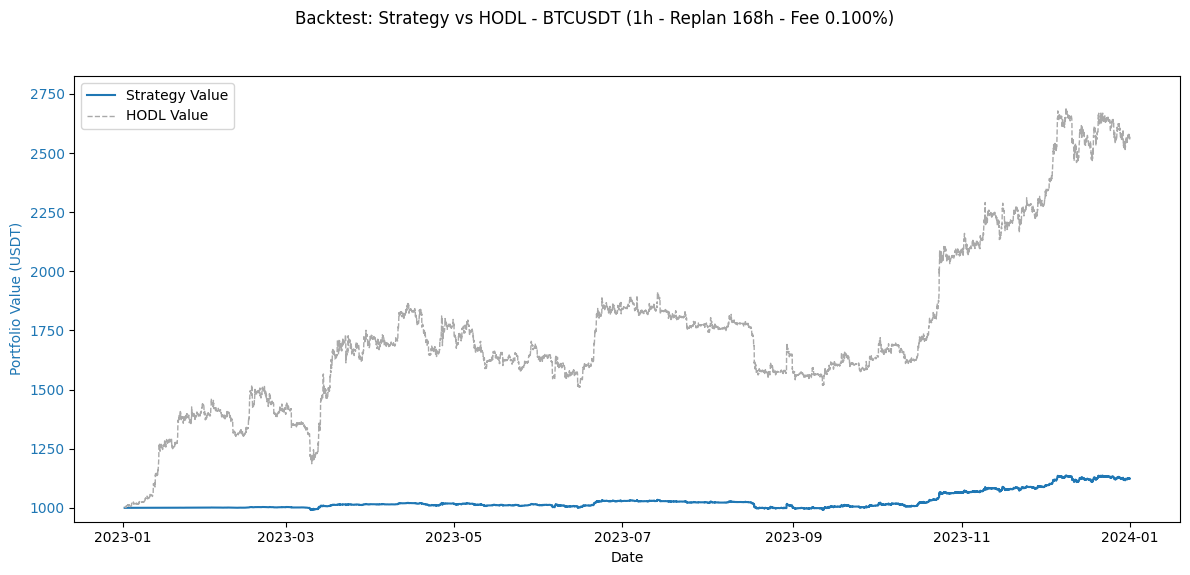

In [23]:
# Cell 8: Backtesting Engine - Geometric Dip-Buying Simulation (v4.5 - Summarize TP MIN_NOTIONAL Skips)

import pandas as pd
from decimal import Decimal, ROUND_DOWN, ROUND_UP, InvalidOperation
import logging
import math
import sys
from datetime import datetime, timezone

# --- Prerequisites ---
if 'client' not in locals() or client is None: raise RuntimeError("Binance client is missing.")
if 'backtest_data' not in locals() or backtest_data.empty: raise RuntimeError("Backtest data missing.")

logger = logging.getLogger(__name__)

logging.info(f"--- Starting Backtest Simulation v4.5 for {BACKTEST_SYMBOL} (Summarize TP Skips + Fees) ---")

# --- Simulation Configuration ---
# (Config remains the same)
STARTING_QUOTE_BALANCE = Decimal('1000.0'); STARTING_BASE_BALANCE = Decimal('0.0')
NUM_ORDERS_PER_SYMBOL_BT = 5; QTY_SCALE_FACTOR_BT = Decimal('1.2'); PRICE_DROP_ATR_MULTI_BT = Decimal('0.3')
TP_ATR_MULTIPLE_BT = Decimal('1.5'); ATR_COL_NAME_BT = f'ATRr_{ATR_PERIOD_BACKTEST}'
REPLAN_INTERVAL_CANDLES = 24 * 7; FEE_RATE = Decimal('0.001')

# --- Fetch Symbol Filters (Once) ---
logging.info(f"Fetching exchange filters for {BACKTEST_SYMBOL}...")
# (Filter fetching code remains the same)
symbol_info_bt = None; price_tick_size_bt = None; min_qty_bt = None; qty_step_size_bt = None; min_notional_bt = Decimal('0')
try:
    exchange_info_bt = client.get_exchange_info(); all_symbols_info_bt = exchange_info_bt.get('symbols', []); symbol_info_lookup_bt = {s['symbol']: s for s in all_symbols_info_bt}
    symbol_info_bt = symbol_info_lookup_bt.get(BACKTEST_SYMBOL); assert symbol_info_bt is not None
    price_tick_size_str = None; min_qty_str = None; qty_step_size_str = None; min_notional_str = None
    for f in symbol_info_bt.get('filters',[]):
        if f['filterType']=='PRICE_FILTER': price_tick_size_str=f.get('tickSize')
        elif f['filterType']=='LOT_SIZE': min_qty_str=f.get('minQty'); qty_step_size_str=f.get('stepSize')
        elif f['filterType'] == 'MIN_NOTIONAL': min_notional_str = f.get('minNotional')
    assert price_tick_size_str and min_qty_str and qty_step_size_str
    price_tick_size_bt = Decimal(price_tick_size_str); min_qty_bt = Decimal(min_qty_str); qty_step_size_bt = Decimal(qty_step_size_str)
    if min_notional_str: min_notional_bt = Decimal(min_notional_str)
    assert price_tick_size_bt > 0 and qty_step_size_bt > 0 and min_qty_bt >= 0 and min_notional_bt >= 0
    logging.info(f"Filters for {BACKTEST_SYMBOL}: TickSize={price_tick_size_bt}, StepSize={qty_step_size_bt}, MinQty={min_qty_bt}, MinNotional={min_notional_bt}")
    logging.info(f"Using Fee Rate for Backtest: {FEE_RATE*100}% ({FEE_RATE})")
except Exception as e:
    logging.error(f"❌ Failed to get/parse filters: {e}"); raise SystemExit("Cannot proceed.")

# --- Simulation State Initialization ---
quote_balance = STARTING_QUOTE_BALANCE; base_balance = STARTING_BASE_BALANCE
open_buy_orders = []; open_sell_orders = []; trade_log = []; portfolio_history = []
total_fees_paid = Decimal('0.0')
# --- New: Counter for skipped TPs ---
tp_skipped_min_notional_count = 0

# --- Helper Functions (remains the same) ---
# ... (adjust_price_bt, adjust_qty_bt, adjust_tp_price_bt) ...
def adjust_price_bt(price, tick_size):
    try: return (price // tick_size) * tick_size if isinstance(price, Decimal) and isinstance(tick_size, Decimal) and tick_size > 0 else None
    except Exception: return None
def adjust_qty_bt(quantity, min_q, step_size):
    try:
        if not (isinstance(quantity,Decimal) and isinstance(min_q,Decimal) and isinstance(step_size,Decimal)): return Decimal('0')
        if step_size <= 0 or quantity < min_q: return Decimal('0')
        num_steps = math.floor((quantity - min_q) / step_size); return min_q + (num_steps * step_size)
    except Exception: return Decimal('0')
def adjust_tp_price_bt(price, tick_size):
    try:
        if not (isinstance(price, Decimal) and isinstance(tick_size, Decimal) and tick_size > 0): return None
        ticks = price / tick_size; adjusted_ticks = ticks.to_integral_value(rounding=ROUND_UP); return adjusted_ticks * tick_size
    except Exception: return None


# --- HODL Calculation Setup ---
# (Remains the same)
initial_hodl_price = backtest_data['Close'].iloc[0]
hodl_base_qty = STARTING_QUOTE_BALANCE / initial_hodl_price if initial_hodl_price > 0 else Decimal('0')
hodl_portfolio_history = []
logging.info(f"Initial HODL Buy: {hodl_base_qty:.8f} {BACKTEST_SYMBOL} @ {initial_hodl_price:.2f}")


# --- Simulation Loop ---
logging.info(f"Starting simulation loop v4.5 through {len(backtest_data)} candles (Replan every {REPLAN_INTERVAL_CANDLES} candles)...")
candle_count = 0; last_replan_candle = 0
for timestamp, candle in backtest_data.iterrows():
    # ... (Loop setup, replan check, progress log remain the same) ...
    candle_count += 1
    current_open = candle['Open']; current_high = candle['High']; current_low = candle['Low']; current_close = candle['Close']
    current_atr = candle[ATR_COL_NAME_BT]
    if current_atr is None: continue
    force_replan_this_candle = False
    if candle_count == 1 or (candle_count - last_replan_candle) >= REPLAN_INTERVAL_CANDLES:
        if open_buy_orders and candle_count != 1: logging.debug(f"[{timestamp}] Replan Interval. Cancelling {len(open_buy_orders)} buys.")
        elif candle_count != 1: logging.debug(f"[{timestamp}] Replan Interval. No buys to cancel.")
        open_buy_orders = []; force_replan_this_candle = True; last_replan_candle = candle_count
    if candle_count % 500 == 0: logging.debug(f"Processing candle {candle_count}/{len(backtest_data)} ({timestamp})")

    # --- 1. Check Fills SELL ---
    # (Logic remains the same - fee applied)
    executed_sell_indices = []
    if open_sell_orders:
        # ... (sell fill logic same as v4.3) ...
        for i, sell_order in enumerate(open_sell_orders):
            if current_high >= sell_order['price']:
                fill_price = sell_order['price']; fill_qty = sell_order['qty']; gross_proceeds = fill_price * fill_qty; fee = gross_proceeds * FEE_RATE; net_proceeds = gross_proceeds - fee; total_fees_paid += fee
                quote_balance += net_proceeds; base_balance = max(Decimal('0'), base_balance - fill_qty); executed_sell_indices.append(i)
                trade_log.append({'timestamp': timestamp, 'type': 'SELL_TP', 'price': fill_price,'qty': fill_qty,'value': net_proceeds,'fee': fee,'buy_fill_price': sell_order['buy_fill_price']}); logging.debug(f"[{timestamp}] SELL_TP Filled."); break
        for index in sorted(executed_sell_indices, reverse=True): del open_sell_orders[index]

    # --- 2. Check Fills BUY ---
    # (Logic remains the same - fee applied)
    executed_buy_indices = []; buy_fill_details = []
    if open_buy_orders:
        # ... (buy fill logic same as v4.3) ...
        open_buy_orders.sort(key=lambda x: x['price'], reverse=True); new_open_buy_orders = []
        for i, buy_order in enumerate(open_buy_orders):
            if current_low <= buy_order['price']:
                fill_price = buy_order['price']; fill_qty = buy_order['qty']; cost = buy_order['notional']; fee = cost * FEE_RATE; total_cost_with_fee = cost + fee
                if quote_balance >= total_cost_with_fee:
                    total_fees_paid += fee; quote_balance -= total_cost_with_fee; base_balance += fill_qty
                    trade_log.append({'timestamp': timestamp, 'type': 'BUY', 'price': fill_price, 'qty': fill_qty,'value': -cost,'fee': fee,'level': buy_order['level']})
                    buy_fill_details.append({'fill_price': fill_price, 'fill_qty': fill_qty}); logging.debug(f"[{timestamp}] BUY Filled (Lvl {buy_order['level']}).")
                else: logging.warning(f"[{timestamp}] BUY Order (Lvl {buy_order['level']}) Insufficient Funds for Cost+Fee."); new_open_buy_orders.append(buy_order)
            else: new_open_buy_orders.append(buy_order)
        open_buy_orders = new_open_buy_orders


    # --- 3. Plan Take Profit ---
    if buy_fill_details:
         for filled_buy in buy_fill_details:
            tp_price_raw = filled_buy['fill_price'] + (TP_ATR_MULTIPLE_BT * current_atr); tp_price_adjusted = adjust_tp_price_bt(tp_price_raw, price_tick_size_bt)
            tp_qty_adjusted = adjust_qty_bt(filled_buy['fill_qty'], min_qty_bt, qty_step_size_bt)
            if tp_price_adjusted and tp_qty_adjusted > 0:
                tp_notional = tp_price_adjusted * tp_qty_adjusted
                if tp_notional >= min_notional_bt:
                    open_sell_orders.append({'price': tp_price_adjusted, 'qty': tp_qty_adjusted, 'buy_fill_price': filled_buy['fill_price']});
                    logging.debug(f"[{timestamp}] TP SELL Placed.")
                else:
                    # --- MODIFICATION: Increment counter instead of logging warning ---
                    tp_skipped_min_notional_count += 1
                    # logging.warning(f"[{timestamp}] TP SELL Order Notional ({tp_notional:.4f}) < MIN_NOTIONAL ({min_notional_bt:.4f}). TP Skipped.") # Removed
            else:
                # Keep warning for invalid calc
                logging.warning(f"[{timestamp}] TP Price/Qty calculation invalid. TP Skipped.")

    # --- 4. Plan New BUY Grid ---
    # (Logic remains the same)
    should_plan_grid = force_replan_this_candle or not open_buy_orders
    if should_plan_grid:
        # ... (Grid planning logic same as v4.3) ...
        if not force_replan_this_candle and not open_buy_orders: logging.debug(f"[{timestamp}] Planning new grid (empty list).")
        elif force_replan_this_candle: logging.debug(f"[{timestamp}] Planning new grid (replan interval).")
        planning_budget_bt = quote_balance; min_value_from_qty_bt = min_qty_bt * current_close
        if planning_budget_bt >= min_value_from_qty_bt:
            logging.debug(f"  Budget={planning_budget_bt:.4f}, MinQtyVal={min_value_from_qty_bt:.4f}.")
            base_target_quote_value = max(min_value_from_qty_bt, min_notional_bt) * Decimal('1.01'); temp_symbol_cost = Decimal('0'); potential_orders_this_candle = []
            target_values_scaled = [base_target_quote_value * (QTY_SCALE_FACTOR_BT**i) for i in range(NUM_ORDERS_PER_SYMBOL_BT)]
            potential_symbol_orders_details = []
            for i in range(NUM_ORDERS_PER_SYMBOL_BT):
                 order_level_display = i + 1; price_drop_levels = i; price_drop = (Decimal(price_drop_levels) * PRICE_DROP_ATR_MULTI_BT * current_atr); raw_price = current_close - price_drop
                 if raw_price <= 0: continue
                 target_quote_value = target_values_scaled[NUM_ORDERS_PER_SYMBOL_BT - 1 - i]; potential_symbol_orders_details.append({"level": order_level_display, "price_raw": raw_price, "target_quote_value": target_quote_value})
            potential_symbol_orders_details.sort(key=lambda x: x['price_raw'], reverse=True)
            for potential_order in potential_symbol_orders_details:
                order_level = potential_order['level']; raw_price = potential_order['price_raw']; target_quote_value = potential_order['target_quote_value']
                adjusted_price = adjust_price_bt(raw_price, price_tick_size_bt);
                if adjusted_price is None or adjusted_price <= 0: continue
                order_qty_base = target_quote_value / adjusted_price if adjusted_price > 0 else Decimal('0'); adjusted_qty = adjust_qty_bt(order_qty_base, min_qty_bt, qty_step_size_bt)
                if adjusted_qty <= 0: continue
                notional_value = adjusted_price * adjusted_qty
                if (planning_budget_bt - temp_symbol_cost) >= notional_value:
                    potential_orders_this_candle.append({"price": adjusted_price, "qty": adjusted_qty, "notional": notional_value, "level": order_level}); temp_symbol_cost += notional_value; logging.debug(f"  Lvl {order_level}: Planned BUY.")
                else: logging.debug(f"  Lvl {order_level}: Insufficient budget."); break
            if potential_orders_this_candle: open_buy_orders = potential_orders_this_candle; logging.debug(f"[{timestamp}] Placed {len(open_buy_orders)} New BUY orders.") # DEBUG
            else: open_buy_orders = []; logging.debug(f"  No BUY orders planned.")
        else: open_buy_orders = []; logging.debug(f"  Insufficient budget for min order.")

    # --- 5. Record Values ---
    current_portfolio_value = quote_balance + (base_balance * current_close); portfolio_history.append({'timestamp': timestamp, 'portfolio_value': current_portfolio_value, 'quote': quote_balance, 'base': base_balance})
    current_hodl_value = hodl_base_qty * current_close; hodl_portfolio_history.append({'timestamp': timestamp, 'hodl_value': current_hodl_value})

logging.info(f"--- Simulation Loop Finished ---") # Keep INFO

# --- Final Portfolio Calculation & Performance Metrics ---
# (Calculations remain the same)
final_quote_balance = quote_balance; final_base_balance = base_balance
last_close_price = backtest_data['Close'].iloc[-1] if not backtest_data.empty else Decimal('0')
final_portfolio_value = final_quote_balance + (final_base_balance * last_close_price)
final_hodl_value = hodl_base_qty * last_close_price
# --- Keep final print statements ---
print("\n--- Backtest Results (v4.5 - Summarize TP Skips) ---") # Updated version in title
print(f"Simulation Period: {backtest_data.index.min()} to {backtest_data.index.max()}")
print(f"Fee Rate Applied: {FEE_RATE*100}%")
print(f"Initial Portfolio Value: {STARTING_QUOTE_BALANCE:.2f} {QUOTE_ASSET}")
print(f"Final Portfolio Value (Strategy): {final_portfolio_value:.2f} {QUOTE_ASSET}")
total_profit_loss = final_portfolio_value - STARTING_QUOTE_BALANCE
total_profit_loss_percent = (total_profit_loss / STARTING_QUOTE_BALANCE) * 100 if STARTING_QUOTE_BALANCE > 0 else Decimal('0')
print(f"Total Profit/Loss (Strategy): {total_profit_loss:.2f} {QUOTE_ASSET} ({total_profit_loss_percent:.2f}%)")
print(f"Final Portfolio Value (HODL): {final_hodl_value:.2f} {QUOTE_ASSET}")
hodl_profit_loss = final_hodl_value - STARTING_QUOTE_BALANCE
hodl_profit_loss_percent = (hodl_profit_loss / STARTING_QUOTE_BALANCE) * 100 if STARTING_QUOTE_BALANCE > 0 else Decimal('0')
print(f"Total Profit/Loss (HODL): {hodl_profit_loss:.2f} {QUOTE_ASSET} ({hodl_profit_loss_percent:.2f}%)")
trades_df = pd.DataFrame(trade_log); buy_trades = trades_df[trades_df['type'] == 'BUY']; sell_trades = trades_df[trades_df['type'] == 'SELL_TP']
print(f"\nTotal Trades Executed (Strategy): {len(trades_df)}")
print(f"  Buy Trades: {len(buy_trades)}")
print(f"  Sell Trades: {len(sell_trades)}")
print(f"Total Fees Paid (Strategy): {total_fees_paid:.4f} {QUOTE_ASSET}")
# --- New: Print count of skipped TPs ---
print(f"TP Orders Skipped (MIN_NOTIONAL): {tp_skipped_min_notional_count}")
if not sell_trades.empty:
    wins = sell_trades[sell_trades['price'] > sell_trades['buy_fill_price']]; win_rate = (len(wins) / len(sell_trades)) * 100 if len(sell_trades) > 0 else 0
    print(f"  TP Sell Win Rate (Sell Price > Buy Fill Price): {win_rate:.2f}% ({len(wins)} wins / {len(sell_trades)} TP sells)")
else: print("  No TP Sell trades executed.")

# --- Plotting (Simplified: Strategy vs HODL only) ---
# (Plotting code remains the same as v4.2)
try:
    import matplotlib.pyplot as plt
    portfolio_df = pd.DataFrame(portfolio_history).set_index('timestamp')
    hodl_df = pd.DataFrame(hodl_portfolio_history).set_index('timestamp')
    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:blue'; ax1.set_xlabel('Date'); ax1.set_ylabel('Portfolio Value (USDT)', color=color)
    strat_line, = ax1.plot(portfolio_df.index, portfolio_df['portfolio_value'].astype(float), color=color, linewidth=1.5, label='Strategy Value')
    hodl_color = 'darkgrey'; hodl_line, = ax1.plot(hodl_df.index, hodl_df['hodl_value'].astype(float), color=hodl_color, linestyle='--', linewidth=1.0, label='HODL Value')
    ax1.tick_params(axis='y', labelcolor=color); min_val = min(portfolio_df['portfolio_value'].astype(float).min(), hodl_df['hodl_value'].astype(float).min()); max_val = max(portfolio_df['portfolio_value'].astype(float).max(), hodl_df['hodl_value'].astype(float).max())
    ax1.set_ylim(bottom=min_val * 0.95, top=max_val * 1.05)
    fig.suptitle(f'Backtest: Strategy vs HODL - {BACKTEST_SYMBOL} ({BACKTEST_KLINE_INTERVAL} - Replan {REPLAN_INTERVAL_CANDLES}h - Fee {FEE_RATE*100}%)')
    handles = [strat_line, hodl_line]; labels = [strat_line.get_label(), hodl_line.get_label()]; ax1.legend(handles, labels, loc='upper left')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
except ImportError: logging.warning("matplotlib not installed. Skipping plot generation. `pip install matplotlib`")
except Exception as plot_err: logging.error(f"Error during plotting: {plot_err}")


# End of Cell 8 (v4.5 - Summarize TP Skips)